# Preference Analysis

## Review Analysis
Conduct textual analysis on reviewers' comments.
Goals:
1. find reviewers' most frequently mentioned issue of concerns
2. find most highly commented listings
3. find most poorly commented listings

In [4]:
import csv
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

### Preparing Data

In [5]:
def open_and_read_file(filename):
    file = pd.read_csv(filename)
    return file

In [6]:
boston_reviews = open_and_read_file("boston_reviews.csv")
seattle_reviews = open_and_read_file("seattle_reviews.csv")

### word count analysis

Create files containing word count in comments, to identify issue of concerns

Extracted priority concerns (in order):
stay, place, apartment, room, location, host, neighborhood, restaurants, bathroom, kitchen, space, parking, distance, station, subway, breakfast, communication, amenities, transportation, shops, towels, shower, beds, pictures, grocery...

In [7]:
def find_sentiment_labels(df, filename):
    file = open(filename, 'w')
    file_out = csv.writer(file)
    word_count = {}
    for i in range(len(df)):
        try:
            comment = df["comments"][i].split(" ")
            for word in comment:
                word = word.strip().lower()
                if word not in word_count.keys():
                    word_count[word] = 1
                else:
                    word_count[word] += 1
        except AttributeError:
            pass
    word_count_items = list(word_count.items())
    sort_word_count = sorted(word_count_items, key=lambda item: item[1], reverse=True)
    for k, v in sort_word_count:
        if v > 50:
            try:
                file_out.writerow([k, v])
            except UnicodeEncodeError:
                pass
    file.close()

In [8]:
find_sentiment_labels(boston_reviews, "boston_comment_word.csv")
find_sentiment_labels(seattle_reviews, "seattle_comment_word.csv")

### sentiment analysis

In [9]:
def sentiment_analysis(df):
    sentiment_score = []
    # Part 2: calculate comment score by review sentiment
    # key words are extracted from the previous output files
    positive_adjectives = "(great|nice|clean|good|comfortable|easy" \
                          "|perfect|wonderful|helpful|beautiful|super" \
                          "|lovely|quite|friendly|convenient|excellent" \
                          "|welcoming|amazing|accommodating|responsive|safe" \
                          "|cozy)"
    positive_actions = "(recommend|home|will|enjoyed|loved|thank|thanks|appreciated)"
    negative_adjectives = "(bad|noisy|poor)"
    positive_1 = re.compile(positive_adjectives)
    positive_2 = re.compile(positive_actions)
    negative_5 = re.compile(negative_adjectives)
    for i in range(len(df)):
        try:
            positivity_1 = re.findall(positive_1, df["comments"][i])
            positivity_2 = re.findall(positive_2, df["comments"][i])
            negativity_1 = re.findall(negative_5, df["comments"][i])
            comment_score = len(positivity_1) + 2*len(positivity_2) - 5*len(negativity_1)
        except TypeError:
            comment_score = 0
        sentiment_score.append(comment_score)
    df.insert(loc=6, column="sentiment", value=sentiment_score)
    return df

In [10]:
def sentiment_score_df(df):
    # calculate the average sentiment score for each listing
    sentiment_by_stay = df.groupby("listing_id")
    sentiment_mean = round(sentiment_by_stay.mean()["sentiment"], 2)
    sentiment_mean = sentiment_mean.sort_values(ascending=False)
    return sentiment_mean

In [11]:
print("###Boston###")
boston_sentiment = sentiment_analysis(boston_reviews)
boston_review_score = sentiment_score_df(boston_sentiment)
boston_high_score = boston_review_score[boston_review_score.values > 10]
boston_low_score = boston_review_score[boston_review_score.values < 0]
print("\nBoston Highly Commented\n", boston_high_score)
print("\nBoston Poorly Commented\n", boston_low_score)

print("\n###Seattle###")
seattle_sentiment = sentiment_analysis(seattle_reviews)
seattle_review_score = sentiment_score_df(seattle_sentiment)
seattle_high_score = seattle_review_score[seattle_review_score.values > 10]
seattle_low_score = seattle_review_score[seattle_review_score.values < 0]
print("\nSeattle Highly Commented\n", seattle_high_score)
print("\nSeattle Poorly Commented\n", seattle_low_score)

###Boston###

Boston Highly Commented
 listing_id
6796364     19.00
7092874     19.00
12603280    16.00
6914622     13.71
12125635    13.50
14220964    13.00
5584915     12.00
5212321     12.00
14125957    11.29
11022736    11.00
8201104     11.00
14603013    11.00
14813006    11.00
7367795     10.50
3593290     10.38
Name: sentiment, dtype: float64

Boston Poorly Commented
 listing_id
6277566    -0.33
13751871   -0.33
6887926    -0.33
1867754    -1.00
10036037   -1.00
14532696   -1.50
4409653    -3.00
Name: sentiment, dtype: float64

###Seattle###

Seattle Highly Commented
 listing_id
6915487    22.00
8988178    18.00
3593582    18.00
3817141    17.00
6022715    16.00
1027860    16.00
5968862    16.00
7676574    15.25
9522082    15.00
8717068    14.00
7278583    14.00
9367465    14.00
7459637    14.00
8765219    13.50
6348159    13.25
3888986    13.00
5648564    13.00
8483744    13.00
9694921    13.00
6808970    13.00
3728802    12.67
670262     12.50
9957555    12.50
8088447    12.00

In [12]:
# store the listing_id of highly&poorly commented listings for furthur comparative analysis
boston_high_score_listing = list(boston_high_score.index)
boston_low_score_listing = list(boston_low_score.index)

seattle_high_score_listing = list(seattle_high_score.index)
seattle_low_score_listing = list(seattle_low_score.index)

## Popularity Analysis
Analyze listing's popularity based on availability days (the less available for future booking, the more popular)

Goals:
1. find properties that has an availability rate less than 30% (considered popular)
2. find commonalities among the popular stays
3. cross-compare properties with low(high) availability rate and high(low) comment score
4. find possible ways to improve popularity

### preparing dataframe

In [13]:
def availability_rate(df, rate, smaller=True):
    if smaller:
        chosen_availability_rate = df.loc[df.availability_365 < (rate*365)]
    else:
        chosen_availability_rate = df.loc[df.availability_365 > (rate*365)]
    return chosen_availability_rate


def host_condition(availability_df):
    availability_host_df = availability_df.loc[:, ["id",
                                                   "availability_365",
                                                   "host_identity_verified",
                                                   "host_is_superhost",
                                                   "host_total_listings_count",
                                                   "host_verifications",
                                                   "host_has_profile_pic"]]
    return availability_host_df


def property_condition(availability_df):
    availability_property_df = availability_df.loc[:, ["neighbourhood",
                                                       "is_location_exact",
                                                       "property_type",
                                                       "room_type",
                                                       "bed_type",
                                                       "bathrooms",
                                                       "bedrooms",
                                                       "amenities",
                                                       "price",
                                                       "review_scores_rating",
                                                       "cancellation_policy"]]
    return availability_property_df

#### Boston

In [77]:
boston_listing = open_and_read_file("boston_listings.csv")
boston_popular_host_df = host_condition(availability_rate(boston_listing, 0.15))
boston_popular_property_df = property_condition(availability_rate(boston_listing, 0.15))
print(boston_popular_host_df.head())
print(boston_popular_property_df.head())

          id  availability_365 host_identity_verified host_is_superhost  \
0   12147973                 0                      f                 f   
12   2684840                 0                      f                 f   
17  13512930                 0                      f                 f   
23   6400432                 0                      t                 f   
24   5498472                 0                      f                 f   

    host_total_listings_count                         host_verifications  \
0                           1  ['email', 'phone', 'facebook', 'reviews']   
12                          2              ['email', 'phone', 'reviews']   
17                          2              ['email', 'phone', 'reviews']   
23                          1       ['email', 'phone', 'reviews', 'kba']   
24                          1                       ['email', 'reviews']   

   host_has_profile_pic  
0                     t  
12                    t  
17            

In [15]:
boston_unpopular_host_df = host_condition(availability_rate(boston_listing, 0.8, smaller=False))
boston_unpopular_property_df = property_condition(availability_rate(boston_listing, 0.8, smaller=False))
print(boston_unpopular_host_df.head())
print(boston_unpopular_property_df.head())

        id  availability_365 host_identity_verified host_is_superhost  \
1  3075044               359                      t                 f   
2     6976               319                      t                 t   
4  7651065               334                      t                 t   
6  5706985               344                      t                 f   
7  2843445               365                      t                 t   

   host_total_listings_count  \
1                          1   
2                          1   
4                          1   
6                          5   
7                          2   

                                  host_verifications host_has_profile_pic  
1  ['email', 'phone', 'facebook', 'linkedin', 'am...                    t  
2             ['email', 'phone', 'reviews', 'jumio']                    t  
4               ['email', 'phone', 'reviews', 'kba']                    t  
6      ['email', 'phone', 'reviews', 'jumio', 'kba']            

#### Seattle

In [16]:
seattle_listing = open_and_read_file("seattle_listings.csv")
seattle_popular_host_df = host_condition(availability_rate(seattle_listing, 0.15))
seattle_popular_property_df = property_condition(availability_rate(seattle_listing, 0.15))
print(seattle_popular_host_df.head())
print(seattle_popular_property_df.head())

         id  availability_365 host_identity_verified host_is_superhost  \
22  8942678                53                      f                 f   
26  9025039                49                      t                 f   
33  5021081                 2                      t                 f   
51  9254900                29                      t                 f   
64  8988281                48                      f                 f   

    host_total_listings_count  \
22                        1.0   
26                        1.0   
33                        1.0   
51                        1.0   
64                        1.0   

                                   host_verifications host_has_profile_pic  
22                               ['phone', 'reviews']                    t  
26  ['email', 'phone', 'facebook', 'reviews', 'jum...                    t  
33  ['email', 'phone', 'facebook', 'google', 'revi...                    t  
51                ['email', 'phone', 'google', '

In [17]:
seattle_unpopular_host_df = host_condition(availability_rate(seattle_listing, 0.8, smaller=False))
seattle_unpopular_property_df = property_condition(availability_rate(seattle_listing, 0.8, smaller=False))
print(seattle_unpopular_host_df.head())
print(seattle_unpopular_property_df.head())

        id  availability_365 host_identity_verified host_is_superhost  \
0   241032               346                      t                 f   
4   278830               365                      t                 f   
5  5956968               302                      t                 f   
6  1909058               346                      t                 t   
8  4948745               341                      t                 f   

   host_total_listings_count  \
0                        3.0   
4                        2.0   
5                        1.0   
6                        1.0   
8                        1.0   

                                  host_verifications host_has_profile_pic  
0               ['email', 'phone', 'reviews', 'kba']                    t  
4   ['email', 'phone', 'facebook', 'reviews', 'kba']                    t  
5   ['email', 'phone', 'facebook', 'reviews', 'kba']                    t  
6               ['email', 'phone', 'reviews', 'kba']            

### Visualization
#### host status analysis

In [18]:
def host_status_analysis(length, feature):
    fig = plt.figure()
    fig.set_size_inches(length, length)

    sub1 = fig.add_subplot(2,2,1)
    sub1.set_title('Boston Popular')
    b_popular = boston_popular_host_df[feature].value_counts(ascending=True)
    sub1.pie(b_popular, labels=b_popular.index, autopct='%1.1f%%', shadow=False)
    sub1.legend(loc=1)

    sub2 = fig.add_subplot(2,2,2)
    sub2.set_title('Boston Unpopular')
    b_unpopular = boston_unpopular_host_df[feature].value_counts(ascending=True)
    sub2.pie(b_unpopular, labels=b_unpopular.index, autopct='%1.1f%%', shadow=False)
    sub2.legend(loc=1)

    sub3 = fig.add_subplot(2,2,3)
    sub3.set_title('Seattle Popular')
    s_popular = seattle_popular_host_df[feature].value_counts(ascending=True)
    sub3.pie(s_popular, labels=s_popular.index, autopct='%1.1f%%', shadow=False)
    sub3.legend(loc=1)

    sub4 = fig.add_subplot(2,2,4)
    sub4.set_title('Seattle Unpopular')
    s_unpopular = seattle_unpopular_host_df[feature].value_counts(ascending=True)
    sub4.pie(s_unpopular, labels=s_unpopular.index, autopct='%1.1f%%', shadow=False)
    sub4.legend(loc=1)

##### host identity varification status

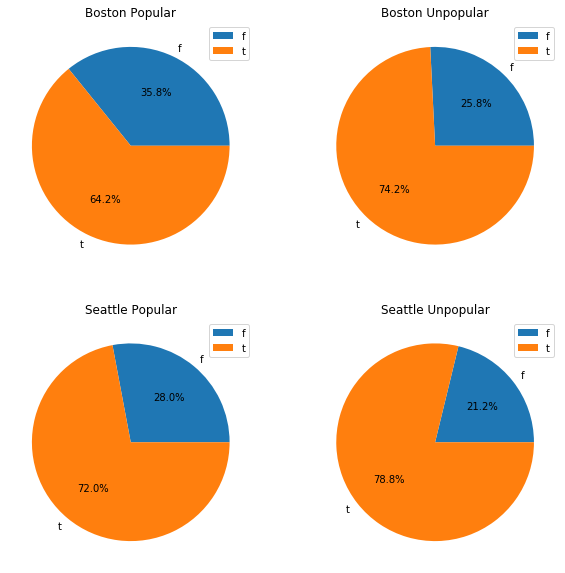

In [19]:
host_status_analysis(10, "host_identity_verified")

##### superhost rate

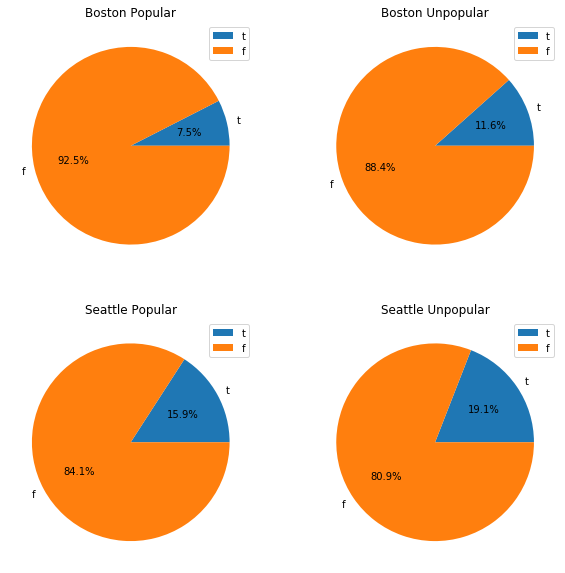

In [20]:
host_status_analysis(10, "host_is_superhost")

##### host total listing

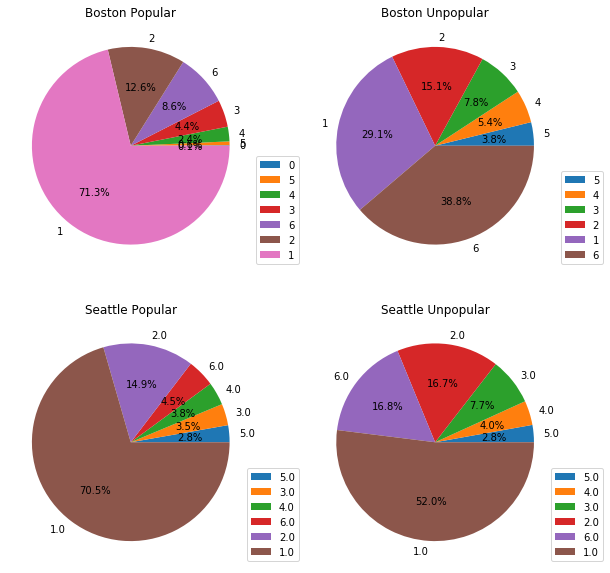

In [21]:
def handeling_more_than_5(df1, df2):
    more_than_5_df = pd.DataFrame(df1.loc[:, "host_total_listings_count"])
    for i in range(len(df2)):
        try:
            # for chain host with more than 5 properties, treated as 6
            if int(more_than_5_df.loc[i]) > 5:
                more_than_5_df.loc[i] = 6
        except KeyError:
            pass
        except ValueError:
            pass
    return more_than_5_df


fig = plt.figure()
fig.set_size_inches(10, 10)

sub1 = fig.add_subplot(2,2,1)
sub1.set_title('Boston Popular')
b_popular = handeling_more_than_5(boston_popular_host_df,boston_listing)["host_total_listings_count"].value_counts(ascending=True)
sub1.pie(b_popular, labels=b_popular.index, autopct='%1.1f%%', shadow=False)
sub1.legend(bbox_to_anchor=(1.2, 0), loc="lower right")

sub2 = fig.add_subplot(2,2,2)
sub2.set_title('Boston Unpopular')
b_unpopular = handeling_more_than_5(boston_unpopular_host_df,boston_listing)["host_total_listings_count"].value_counts(ascending=True)
sub2.pie(b_unpopular, labels=b_unpopular.index, autopct='%1.1f%%', shadow=False)
sub2.legend(bbox_to_anchor=(1.2, 0), loc="lower right")

sub3 = fig.add_subplot(2,2,3)
sub3.set_title('Seattle Popular')
s_popular = handeling_more_than_5(seattle_popular_host_df,seattle_listing)["host_total_listings_count"].value_counts(ascending=True)
sub3.pie(s_popular, labels=s_popular.index, autopct='%1.1f%%', shadow=False)
sub3.legend(bbox_to_anchor=(1.2, 0), loc="lower right")

sub4 = fig.add_subplot(2,2,4)
sub4.set_title('Seattle Unpopular')
s_unpopular = handeling_more_than_5(seattle_unpopular_host_df,seattle_listing)["host_total_listings_count"].value_counts(ascending=True)
sub4.pie(s_unpopular, labels=s_unpopular.index, autopct='%1.1f%%', shadow=False)
sub4.legend(bbox_to_anchor=(1.2, 0), loc="lower right")

##### host verification accessibility on social media

In [22]:
def split_verification_str(lst, df2):
    verification_list = []
    for df in lst:
        dic = {}
        dic2 = {}
        for i in range(len(df2)):
            try:
                methods_list = df.loc[i, "host_verifications"][1:-1].split(", ")
                for method in methods_list:
                    method = method[1:-1]
                    method = method.strip()
                    if method not in dic.keys():
                        dic[method] = 1
                    else:
                        dic[method] += 1
                    dic2[method] = f"{round((dic[method]/len(df))*100,2)}%"
            except KeyError:
                pass
        verification_list.append(dic)
        verification_list.append(dic2)
    method_df = pd.DataFrame(verification_list)
    return method_df

##### #Boston#

In [23]:
df_list_b = [boston_popular_host_df, boston_unpopular_host_df]
split_verification_str(df_list_b, boston_listing)

,,amex,email,facebook,google,jumio,kba,linkedin,manual_offline,manual_online,phone,reviews,sent_id,weibo
0,1,26,1080,227,37,402,374,29,57,18,1124,967,3,7
1,0.09%,2.3%,95.49%,20.07%,3.27%,35.54%,33.07%,2.56%,5.04%,1.59%,99.38%,85.5%,0.27%,0.62%
2,NaN,42,1283,218,36,530,490,26,15,4,1301,1238,NaN,1
3,NaN,3.22%,98.47%,16.73%,2.76%,40.68%,37.61%,2.0%,1.15%,0.31%,99.85%,95.01%,NaN,0.08%


##### #Seattle#

In [24]:
df_list_s = [seattle_popular_host_df, seattle_unpopular_host_df]
split_verification_str(df_list_s, seattle_listing)

,,amex,email,facebook,google,jumio,kba,linkedin,manual_offline,manual_online,phone,photographer,reviews,sent_id,weibo
0,1,10,379,215,94,123,179,101,1,1,389,NaN,328,NaN,NaN
1,0.25%,2.51%,95.23%,54.02%,23.62%,30.9%,44.97%,25.38%,0.25%,0.25%,97.74%,NaN,82.41%,NaN,NaN
2,1,6,1973,985,358,724,919,458,34,4,2021,3,1904,8,1
3,0.05%,0.3%,97.29%,48.57%,17.65%,35.7%,45.32%,22.58%,1.68%,0.2%,99.65%,0.15%,93.89%,0.39%,0.05%


#### property status analysis

In [25]:
def property_status_analysis(length, feature, loc):
    fig = plt.figure()
    fig.set_size_inches(length, length)

    sub1 = fig.add_subplot(2,2,1)
    sub1.set_title('Boston Popular')
    b_popular = boston_popular_property_df[feature].value_counts(ascending=True)
    sub1.pie(b_popular, labels=b_popular.index, autopct='%1.1f%%', shadow=False)
    sub1.legend(loc=loc)

    sub2 = fig.add_subplot(2,2,2)
    sub2.set_title('Boston Unpopular')
    b_unpopular = boston_unpopular_property_df[feature].value_counts(ascending=True)
    sub2.pie(b_unpopular, labels=b_unpopular.index, autopct='%1.1f%%', shadow=False)
    sub2.legend(loc=loc)

    sub3 = fig.add_subplot(2,2,3)
    sub3.set_title('Seattle Popular')
    s_popular = seattle_popular_property_df[feature].value_counts(ascending=True)
    sub3.pie(s_popular, labels=s_popular.index, autopct='%1.1f%%', shadow=False)
    sub3.legend(loc=loc)

    sub4 = fig.add_subplot(2,2,4)
    sub4.set_title('Seattle Unpopular')
    s_unpopular = seattle_unpopular_property_df[feature].value_counts(ascending=True)
    sub4.pie(s_unpopular, labels=s_unpopular.index, autopct='%1.1f%%', shadow=False)
    sub4.legend(loc=loc)

##### neighborhood

Text(0.5, 1.0, 'Boston Property by Neighborhood')

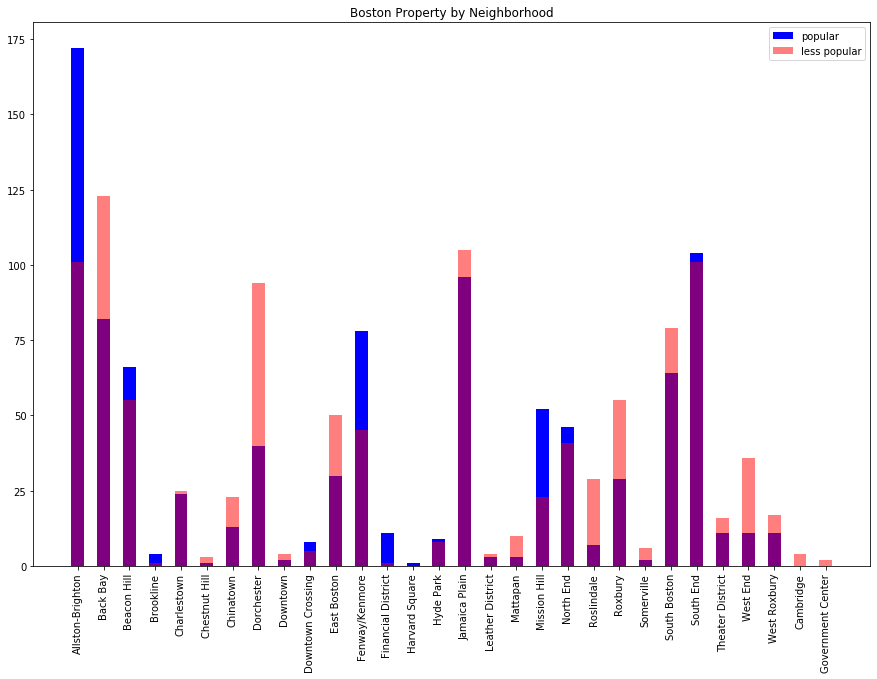

In [26]:
b_popular_counts = boston_popular_property_df.groupby("neighbourhood").size()
b_unpopular_counts = boston_unpopular_property_df.groupby("neighbourhood").size()

plt.figure(figsize=(15,10))
w = 0.5

plt.bar(b_popular_counts.index, b_popular_counts.values, width=w, color="blue")
plt.xticks(rotation=90)
plt.bar(b_unpopular_counts.index, b_unpopular_counts.values, width=w, color="red", alpha=0.5)
plt.legend(["popular","less popular"], loc="upper right")
plt.title('Boston Property by Neighborhood')

Text(0.5, 1.0, 'Seattle Property by Neighborhood')

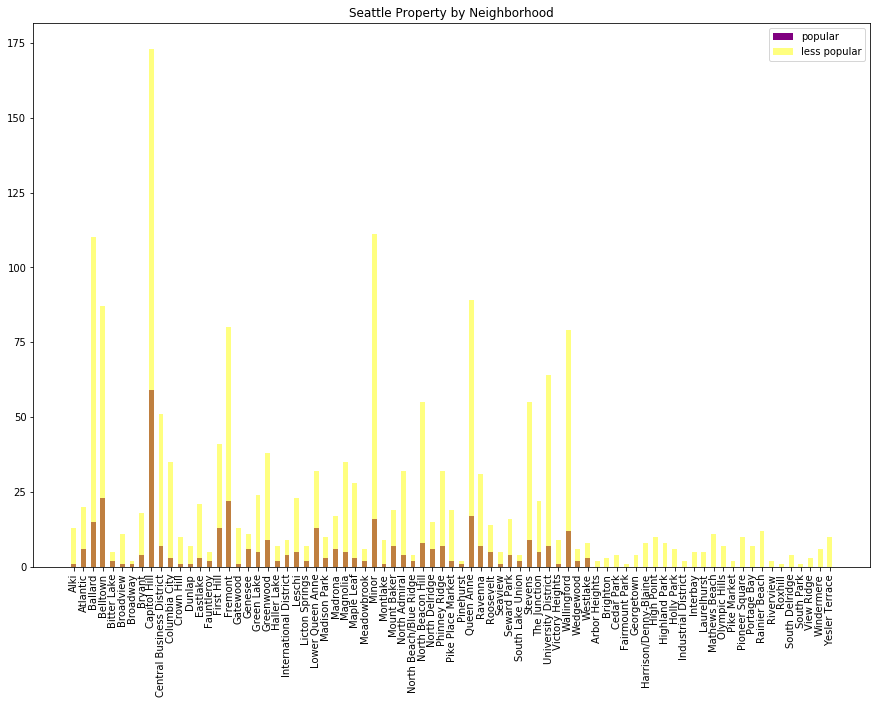

In [27]:
s_popular_counts = seattle_popular_property_df.groupby("neighbourhood").size()
s_unpopular_counts = seattle_unpopular_property_df.groupby("neighbourhood").size()

plt.figure(figsize=(15,10))
w = 0.5

plt.bar(s_popular_counts.index, s_popular_counts.values, width=w, color="purple")
plt.xticks(rotation=90)
plt.bar(s_unpopular_counts.index, s_unpopular_counts.values, width=w, color="yellow", alpha=0.5)
plt.legend(["popular","less popular"], loc="upper right")
plt.title('Seattle Property by Neighborhood')

##### whether location description is exact

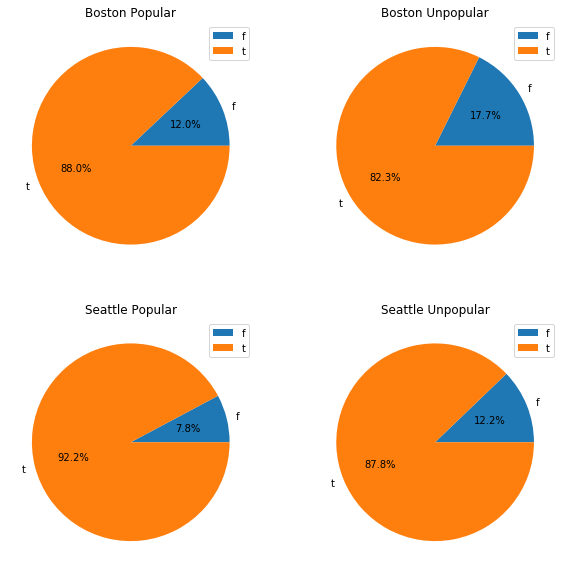

In [28]:
property_status_analysis(10, "is_location_exact", 1)

##### property type

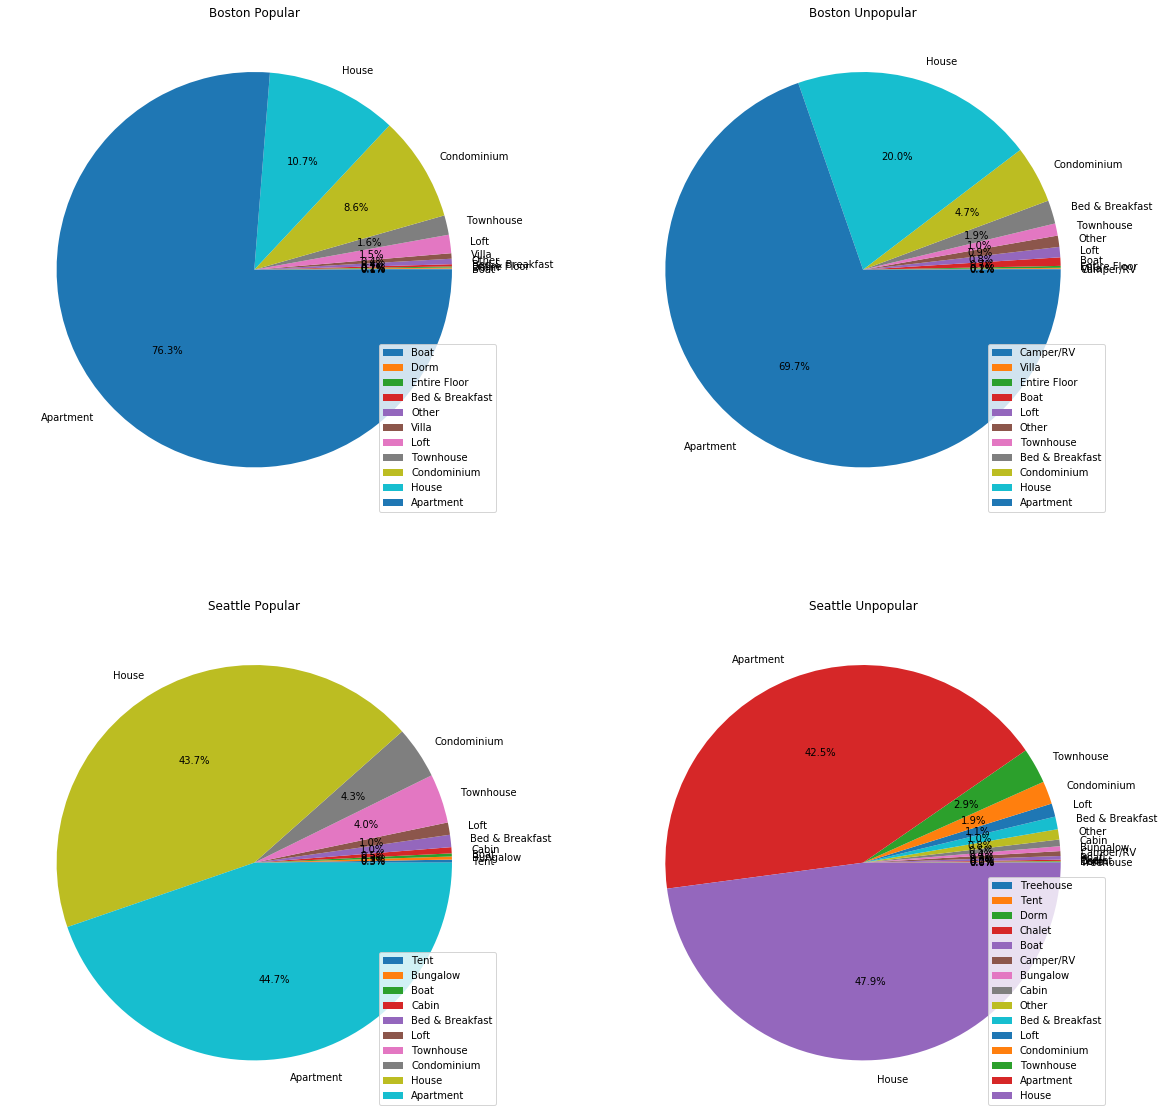

In [29]:
property_status_analysis(20, "property_type", 4)

##### room type

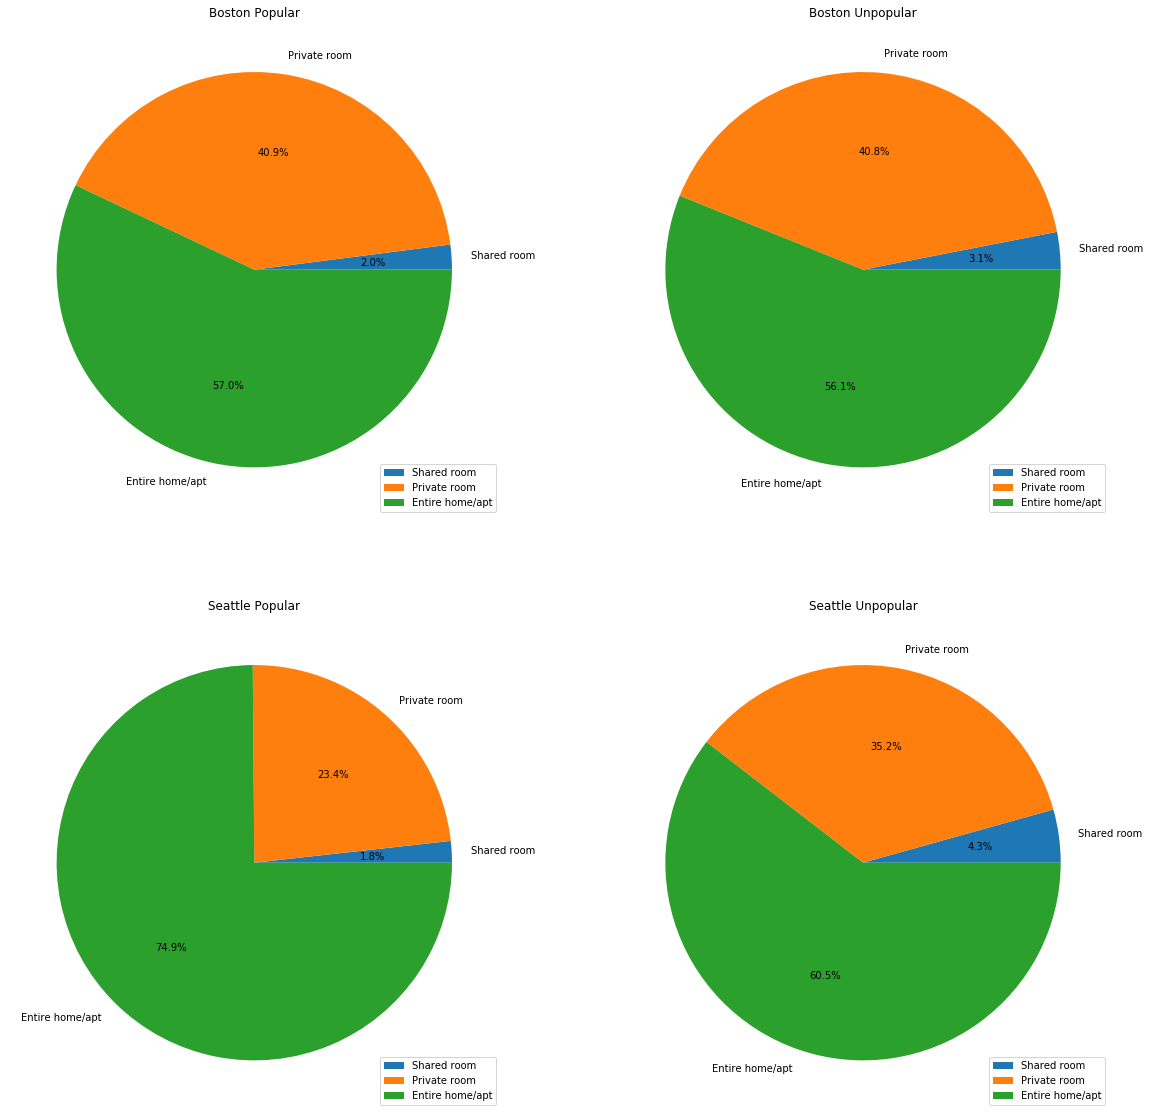

In [30]:
property_status_analysis(20, "room_type", 4)

#####  bed type

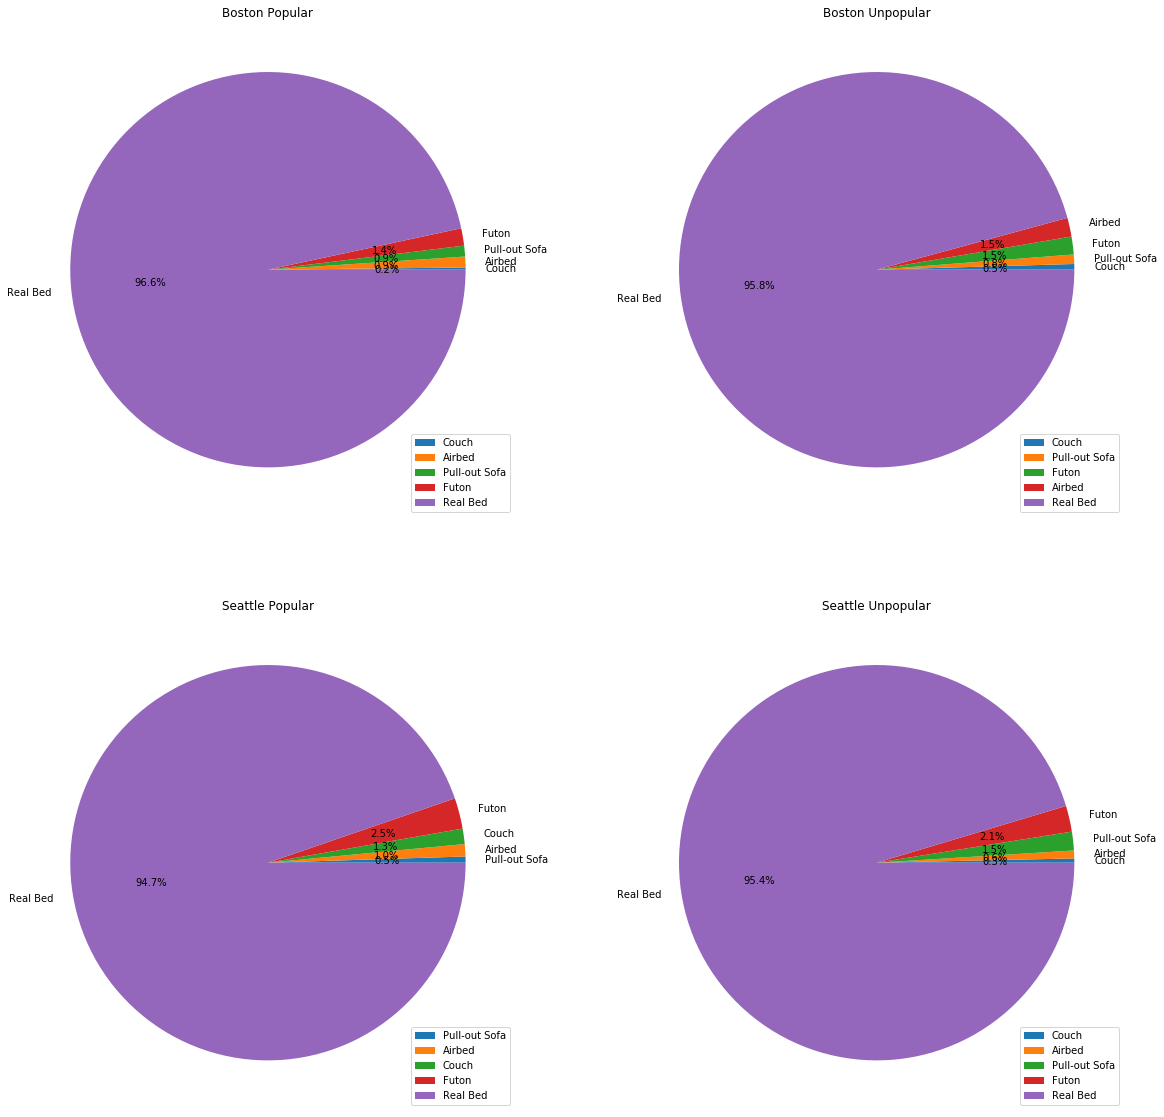

In [31]:
property_status_analysis(20, "bed_type", 4)

##### cancellation policy

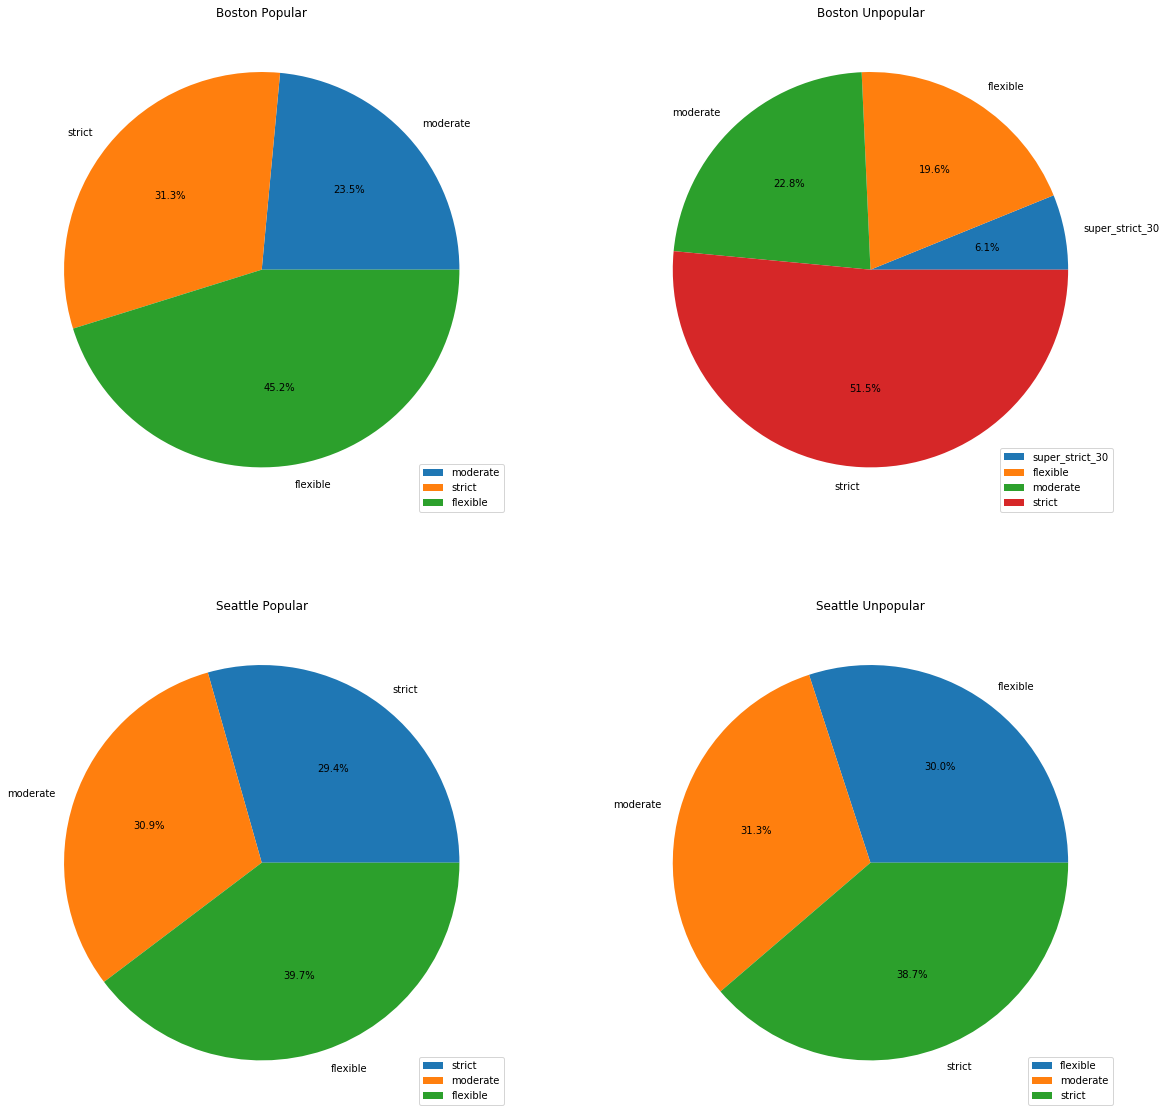

In [32]:
property_status_analysis(20, "cancellation_policy", 4)

##### amenities

In [35]:
def amenities_analysis(lst, df2):
    amenities_list = []
    for df in lst:
        dic = {}
        dic2 = {}
        for i in range(len(df2)):
            try:
                amenity_list = df.loc[i, "amenities"][1:-1].split(",")
                for amenity in amenity_list:
                    try:
                        if amenity[0] == '"':
                            amenity = amenity[1:-1]
                    except IndexError:
                        pass
                    if amenity not in dic.keys():
                        dic[amenity] = 1
                    else:
                        dic[amenity] += 1
                    dic2[amenity] = f"{round((dic[amenity]/len(df))*100,2)}%"

            except KeyError:
                pass
        amenities_list.append(dic)
        amenities_list.append(dic2)
        amenities_df = pd.DataFrame(amenities_list)
    return amenities_df

##### #Boston#

In [37]:
property_list_b = [boston_popular_property_df, boston_unpopular_property_df]
amenities_analysis(property_list_b, boston_listing)

,,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,...,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
0,17,340,817,90,341,467,761,48,59,83,...,963,40,41,775,781,NaN,54,1063,136,171
1,1.5%,30.06%,72.24%,7.96%,30.15%,41.29%,67.29%,4.24%,5.22%,7.34%,...,85.15%,3.54%,3.63%,68.52%,69.05%,NaN,4.77%,93.99%,12.02%,15.12%
2,11,424,1049,114,249,674,905,62,91,66,...,1048,32,55,950,849,1,60,1234,174,207
3,0.84%,32.54%,80.51%,8.75%,19.11%,51.73%,69.46%,4.76%,6.98%,5.07%,...,80.43%,2.46%,4.22%,72.91%,65.16%,0.08%,4.6%,94.7%,13.35%,15.89%


##### #Seattle#

In [40]:
property_list_s = [seattle_popular_property_df, seattle_unpopular_property_df]
amenities_analysis(property_list_s, seattle_listing)

,,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,...,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,3,68,67,24,51,129,249,41,44,7,...,75,263,341,9,17,279,331,NaN,33,377
1,0.75%,17.09%,16.83%,6.03%,12.81%,32.41%,62.56%,10.3%,11.06%,1.76%,...,18.84%,66.08%,85.68%,2.26%,4.27%,70.1%,83.17%,NaN,8.29%,94.72%
2,27,307,357,163,241,824,1265,193,278,39,...,336,1383,1703,46,136,1324,1560,1,128,1942
3,1.33%,15.14%,17.6%,8.04%,11.88%,40.63%,62.38%,9.52%,13.71%,1.92%,...,16.57%,68.2%,83.97%,2.27%,6.71%,65.29%,76.92%,0.05%,6.31%,95.76%


##### price by neighborhood

In [78]:
def type_change(df1, df2, feature, a, b):
    for i in range(len(df2)):
        try:
            if "," in df1.loc[i, feature]:
                df1.loc[i, feature] = df1.loc[i, feature].replace(",", "")
            df1.loc[i, feature] = int(df1.loc[i, feature][a:b])
        except KeyError:
            pass
        except TypeError:
            pass
    return df1

In [91]:
def get_mean(df, groupfeature, meanfeature):
    group_by = df.groupby(groupfeature)
    feature_mean = round(group_by.mean()[meanfeature], 2)
    feature_mean = feature_mean.sort_values(ascending=False)
    return feature_mean

In [92]:
b_popular_property_df = type_change(boston_popular_property_df, boston_listing, 'price', 1, -3)
get_mean(b_popular_property_df, "neighbourhood", "price")

neighbourhood
Theater District      301.73
South Boston          277.58
Downtown Crossing     270.50
Financial District    267.09
Harvard Square        259.00
Downtown              236.00
Back Bay              228.66
West End              226.55
Charlestown           224.67
Chinatown             212.77
Leather District      211.00
South End             198.57
Beacon Hill           194.27
North End             190.02
Roxbury               166.79
Fenway/Kenmore        165.51
Roslindale            126.86
Hyde Park             123.89
Jamaica Plain         117.48
East Boston           115.40
West Roxbury          114.09
Dorchester            112.72
Mission Hill          108.62
Brookline             103.50
Allston-Brighton       98.40
Somerville             76.00
Mattapan               63.00
Chestnut Hill          50.00
Name: price, dtype: float64

In [93]:
b_unpopular_property_df = type_change(boston_unpopular_property_df, boston_listing, 'price', 1, -3)
get_mean(b_unpopular_property_df, "neighbourhood", "price")

neighbourhood
Financial District    375.00
Downtown Crossing     336.80
Fenway/Kenmore        334.60
Leather District      293.50
Back Bay              259.96
Chinatown             241.57
Charlestown           241.32
Cambridge             236.00
Beacon Hill           233.53
West End              232.64
South End             226.57
South Boston          211.85
Government Center     208.50
North End             205.10
Theater District      188.50
Roxbury               158.33
Mission Hill          157.61
Jamaica Plain         156.36
East Boston           141.54
Allston-Brighton      134.36
Downtown              131.25
West Roxbury          129.00
Somerville             99.00
Roslindale             97.62
Dorchester             88.62
Mattapan               86.60
Brookline              85.00
Chestnut Hill          77.67
Hyde Park              67.00
Name: price, dtype: float64

Text(0.5, 1.0, 'Boston Property Average Price by Neighborhood')

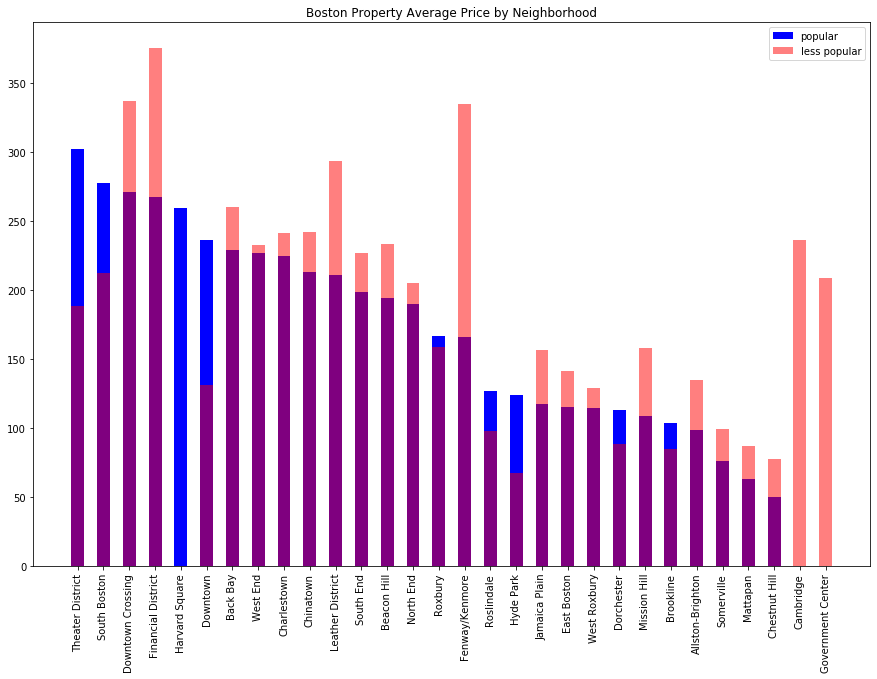

In [103]:
price_popular = get_mean(b_popular_property_df, "neighbourhood", "price")
price_unpopular = get_mean(b_unpopular_property_df, "neighbourhood", "price")

plt.figure(figsize=(15,10))
w = 0.5

plt.bar(price_popular.index, price_popular.values, width=w, color="blue")
plt.xticks(rotation=90)
plt.bar(price_unpopular.index, price_unpopular.values, width=w, color="red", alpha=0.5)
plt.legend(["popular","less popular"], loc="upper right")
plt.title('Boston Property Average Price by Neighborhood')

In [95]:
s_popular_property_df = type_change(seattle_popular_property_df, seattle_listing, 'price', 1, -3)
get_mean(s_popular_property_df, "neighbourhood", "price")

neighbourhood
Montlake                     750.00
Green Lake                   229.80
Phinney Ridge                220.86
Stevens                      202.11
Madison Park                 198.33
Broadview                    195.00
Gatewood                     195.00
Leschi                       190.00
North Admiral                189.50
Wedgewood                    187.00
Wallingford                  183.25
Belltown                     178.43
The Junction                 175.80
Queen Anne                   160.35
Pinehurst                    150.00
Genesee                      149.33
Minor                        146.06
Central Business District    143.57
Ballard                      135.33
Bryant                       134.75
Victory Heights              129.00
Westlake                     128.00
Magnolia                     127.60
Pike Place Market            127.50
Fremont                      123.86
Capitol Hill                 121.15
Alki                         120.00
Greenwood     

In [96]:
s_unpopular_property_df = type_change(seattle_unpopular_property_df, seattle_listing, 'price', 1, -3)
get_mean(s_unpopular_property_df, "neighbourhood", "price")

neighbourhood
Fairmount Park               370.00
Portage Bay                  285.29
Industrial District          235.00
Alki                         225.23
Westlake                     223.75
Fauntleroy                   210.20
Magnolia                     187.86
Windermere                   184.50
Pike Place Market            184.32
Queen Anne                   176.83
Central Business District    164.10
Belltown                     163.61
Green Lake                   163.54
Madison Park                 152.80
North Admiral                149.31
Madrona                      148.06
Pioneer Square               146.60
Lower Queen Anne             145.44
First Hill                   145.39
Seaview                      143.80
South Lake Union             143.75
Montlake                     141.56
Yesler Terrace               138.80
Minor                        133.07
Pinehurst                    132.00
Capitol Hill                 130.00
Arbor Heights                127.00
Fremont       

Text(0.5, 1.0, 'Seattle Property Average Price by Neighborhood')

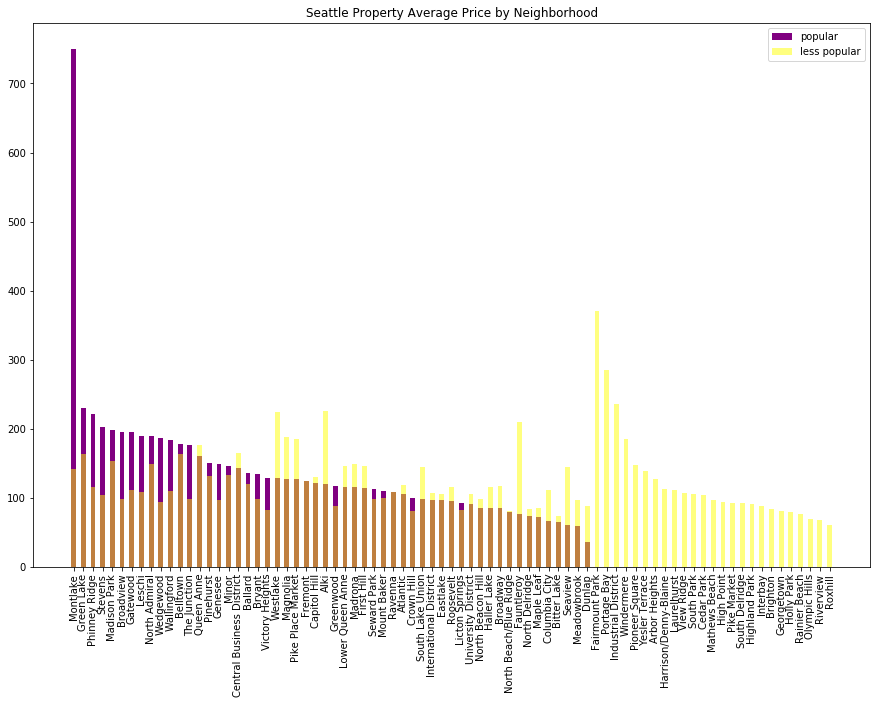

In [102]:
price_popular = get_mean_price(s_popular_property_df)
price_unpopular = get_mean_price(s_unpopular_property_df)

plt.figure(figsize=(15,10))
w = 0.5

plt.bar(price_popular.index, price_popular.values, width=w, color="purple")
plt.xticks(rotation=90)
plt.bar(price_unpopular.index, price_unpopular.values, width=w, color="yellow", alpha=0.5)
plt.legend(["popular","less popular"], loc="upper right")
plt.title('Seattle Property Average Price by Neighborhood')

##### review scores rating
##### 1. average by neighborhood

In [98]:
b_popular_property_df = type_change(boston_popular_property_df, boston_listing, 'review_scores_rating', 0, -1)
get_mean(b_popular_property_df, "neighbourhood", "review_scores_rating")

neighbourhood
Brookline             100.00
Financial District    100.00
Leather District      100.00
Roslindale             98.40
West Roxbury           97.14
North End              96.85
West End               96.83
Hyde Park              96.33
South Boston           95.89
Somerville             95.00
Downtown               95.00
Charlestown            95.00
Beacon Hill            94.38
South End              94.30
Jamaica Plain          93.96
Back Bay               93.54
Dorchester             93.23
Fenway/Kenmore         92.02
Theater District       91.67
East Boston            91.50
Roxbury                89.45
Chinatown              89.00
Downtown Crossing      88.20
Allston-Brighton       87.65
Mission Hill           86.74
Mattapan               80.00
Chestnut Hill            NaN
Harvard Square           NaN
Name: review_scores_rating, dtype: float64

In [99]:
b_unpopular_property_df = type_change(boston_unpopular_property_df, boston_listing, 'review_scores_rating', 0, -1)
get_mean(b_unpopular_property_df, "neighbourhood", "review_scores_rating")

neighbourhood
Financial District    98.00
Leather District      97.33
Hyde Park             96.67
West Roxbury          96.07
Roslindale            94.41
Charlestown           93.52
North End             93.44
South Boston          93.41
Jamaica Plain         93.40
Beacon Hill           93.06
Government Center     92.50
West End              91.78
Downtown Crossing     91.75
Allston-Brighton      91.69
Chinatown             91.62
South End             91.31
Back Bay              91.13
Mission Hill          90.80
Chestnut Hill         90.00
Roxbury               89.85
Mattapan              89.60
Fenway/Kenmore        89.43
East Boston           88.59
Theater District      87.57
Somerville            86.67
Dorchester            86.20
Downtown              82.00
Cambridge             74.50
Brookline               NaN
Name: review_scores_rating, dtype: float64

Text(0.5, 1.0, 'Boston Property Average Score by Neighborhood')

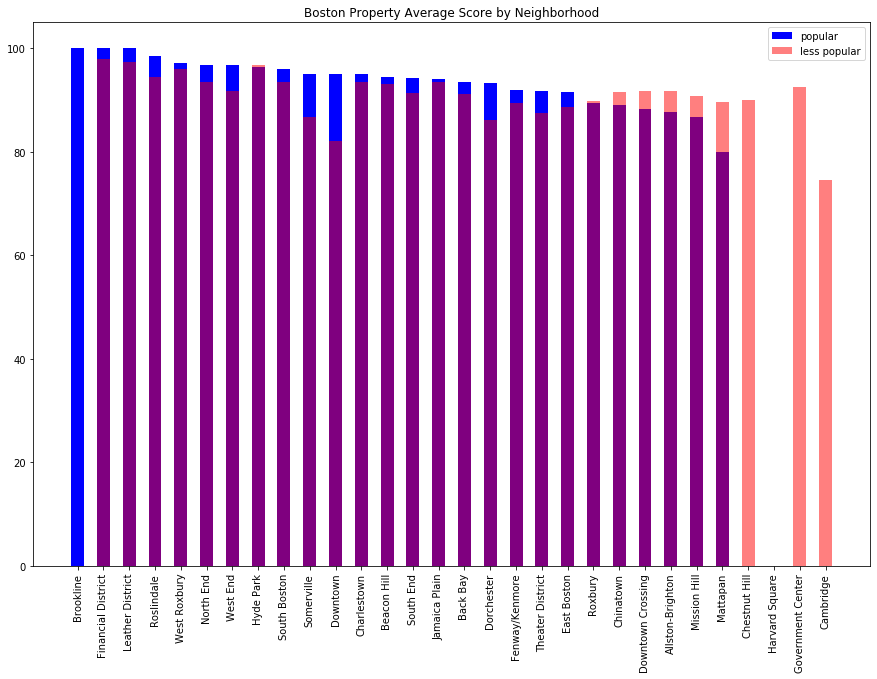

In [128]:
score_popular = get_mean(b_popular_property_df, "neighbourhood", "review_scores_rating")
score_unpopular = get_mean(b_unpopular_property_df, "neighbourhood", "review_scores_rating")

plt.figure(figsize=(15,10))
w = 0.5

plt.bar(score_popular.index, score_popular.values, width=w, color="blue")
plt.xticks(rotation=90)
plt.bar(score_unpopular.index, score_unpopular.values, width=w, color="red", alpha=0.5)
plt.legend(["popular","less popular"], loc="upper right")
plt.title('Boston Property Average Score by Neighborhood')

In [105]:
s_popular_property_df = type_change(seattle_popular_property_df, seattle_listing, 'review_scores_rating', 0, -1)
get_mean(s_popular_property_df, "neighbourhood", "review_scores_rating")

neighbourhood
Meadowbrook                  100.00
South Lake Union             100.00
North Beach/Blue Ridge       100.00
Roosevelt                    100.00
Bitter Lake                  100.00
Montlake                      99.00
Fauntleroy                    98.50
Madrona                       98.33
Broadview                     98.00
Licton Springs                98.00
Central Business District     97.67
Seward Park                   97.67
North Delridge                97.50
Minor                         97.13
Magnolia                      97.00
Columbia City                 97.00
Ravenna                       96.71
Greenwood                     96.50
Stevens                       96.25
Lower Queen Anne              96.17
Maple Leaf                    96.00
International District        96.00
Green Lake                    96.00
Fremont                       95.56
Capitol Hill                  95.55
Atlantic                      95.20
Wallingford                   95.14
First Hill    

In [106]:
s_unpopular_property_df = type_change(seattle_unpopular_property_df, seattle_listing, 'review_scores_rating', 0, -1)
get_mean(s_unpopular_property_df, "neighbourhood", "review_scores_rating")

neighbourhood
Madison Park                 99.14
Arbor Heights                98.00
Portage Bay                  98.00
Gatewood                     97.90
North Beach/Blue Ridge       97.67
High Point                   97.43
Windermere                   97.40
Riverview                    97.00
Genesee                      97.00
Licton Springs               97.00
Yesler Terrace               96.89
Crown Hill                   96.88
Madrona                      96.88
Lower Queen Anne             96.71
Broadview                    96.60
Phinney Ridge                96.32
North Admiral                96.26
Harrison/Denny-Blaine        96.14
Westlake                     96.00
Leschi                       95.95
Victory Heights              95.89
Green Lake                   95.88
Highland Park                95.83
Fauntleroy                   95.60
Meadowbrook                  95.50
Minor                        95.50
Brighton                     95.50
Ballard                      95.48
Queen 

Text(0.5, 1.0, 'Seattle Property Average Score by Neighborhood')

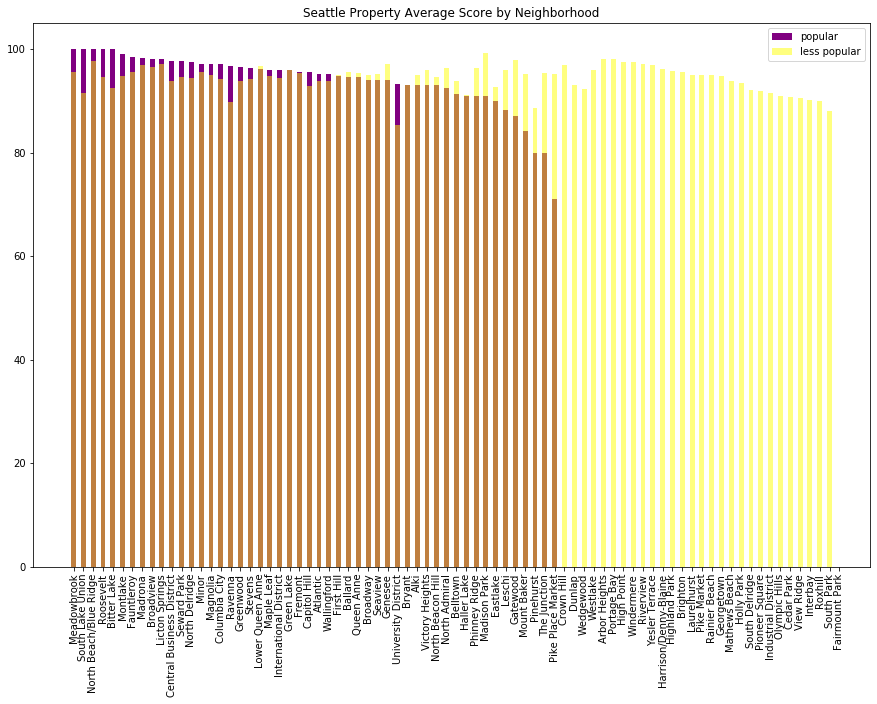

In [127]:
score_popular = get_mean(s_popular_property_df, "neighbourhood", "review_scores_rating")
score_unpopular = get_mean(s_unpopular_property_df, "neighbourhood", "review_scores_rating")

plt.figure(figsize=(15,10))
w = 0.5

plt.bar(score_popular.index, score_popular.values, width=w, color="purple")
plt.xticks(rotation=90)
plt.bar(score_unpopular.index, score_unpopular.values, width=w, color="yellow", alpha=0.5)
plt.legend(["popular","less popular"], loc="upper right")
plt.title('Seattle Property Average Score by Neighborhood')

##### 2. score histogram

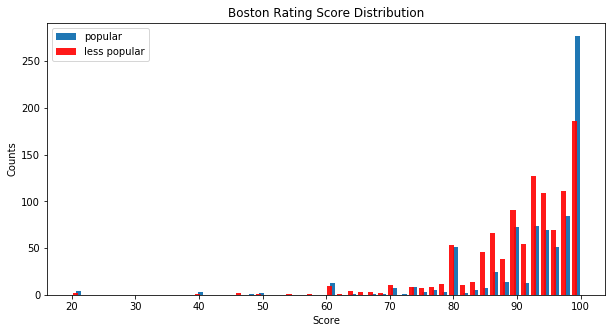

In [123]:
plt.figure(figsize=(10,5))
plt.hist(b_popular_property_df["review_scores_rating"]+0.25, bins=50, rwidth=0.5)
plt.hist(b_unpopular_property_df["review_scores_rating"]-0.25, bins=50, rwidth=0.5, color="red", alpha=0.9)
plt.xlabel("Score")
plt.ylabel("Counts")
plt.title("Boston Rating Score Distribution")
plt.legend(["popular","less popular"], loc="upper left")

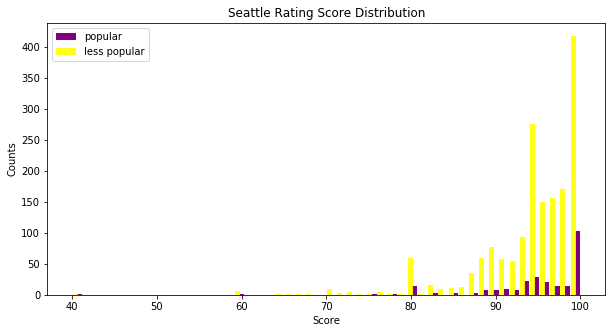

In [124]:
plt.figure(figsize=(10,5))
plt.hist(s_popular_property_df["review_scores_rating"]+0.25, bins=50, rwidth=0.5, color="purple")
plt.hist(s_unpopular_property_df["review_scores_rating"]-0.25, bins=50, rwidth=0.5, color="yellow", alpha=0.9)
plt.xlabel("Score")
plt.ylabel("Counts")
plt.title("Seattle Rating Score Distribution")
plt.legend(["popular","less popular"], loc="upper left")

# Price Analysis
Among all available columns of data, choose potential price affecting factors and run statistical tests on their correlationship

## Creating Price Analysis DataFrame
Chosen Potential Factors: 
numerical: accommodates, bathrooms, bedrooms, beds, amenities numbers (process needed), minimum_nights, maximum_nights, availability_365, review_scores_rating, security_deposit (NaN as 0)
categorical: neighborhood, property_type, room_type, cancellation_policy
Note: For non-integer categorical variables, to analyze the association between the factor and price, price are also divided into 5 levels as categorical variable, price_level

In [139]:
def numeric_factors(df):
    factor_list = ['price', 'accommodates', 'availability_365', 'review_scores_rating', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights']
    numeric_factors_df = df.loc[:, factor_list]
    type_change(numeric_factors_df, df, 'price', 1, -3)
    for column in factor_list[1::]:
        numeric_factors_df[column] = pd.to_numeric(numeric_factors_df[column])
    return numeric_factors_df

In [140]:
numeric_factors(boston_listing)

,price,accommodates,availability_365,review_scores_rating,bathrooms,bedrooms,beds,minimum_nights,maximum_nights
0,250,4,0,NaN,1.5,2.0,3.0,2,1125
1,65,2,359,94.0,1.0,1.0,1.0,2,15
2,65,2,319,98.0,1.0,1.0,1.0,3,45
3,75,4,98,100.0,1.0,1.0,2.0,1,1125
4,79,2,334,99.0,1.5,1.0,2.0,2,31
5,75,2,58,100.0,1.0,1.0,1.0,2,1125
6,100,3,344,90.0,1.0,1.0,2.0,1,1125
7,75,2,365,96.0,2.0,1.0,1.0,1,1125
8,58,2,347,96.0,1.0,1.0,2.0,2,1125
9,229,5,107,94.0,1.0,2.0,2.0,4,10


In [141]:
b_numeric_var_df = numeric_factors(boston_listing)
b_numeric_var_df.isnull().sum()

price                     0
accommodates              0
availability_365          0
review_scores_rating    813
bathrooms                14
bedrooms                 10
beds                      9
minimum_nights            0
maximum_nights            0
dtype: int64

In [148]:
b_numeric_var_df.dropna(inplace=True)
variable_list = ['accommodates', 'availability_365', 'review_scores_rating', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights']
for variable in variable_list:
    correlation = np.corrcoef(b_numeric_var_df.price, b_numeric_var_df[variable])
    print(f"{variable}: {correlation[0][1]:.2f}")

accommodates: 0.59
availability_365: 0.08
review_scores_rating: 0.10
bathrooms: 0.34
bedrooms: 0.54
beds: 0.52
minimum_nights: -0.02
maximum_nights: -0.01


#### Boston numerical variable analysis
|Variable|Correlation Coefficient (r)|
|--------|----------|
|accommodates|0.59|
|availability_365|0.08|
|review_scores_rating|0.10|
|bathrooms|0.34|
|bedrooms|0.54|
|beds|0.52|
|minimum_nights|-0.02|
|maximum_nights|-0.01|

In [133]:
numeric_factors(seattle_listing)

,price,accommodates,availability_365,review_scores_rating,bathrooms,bedrooms,beds,minimum_nights,maximum_nights
0,85,4,346,95.0,1.0,1.0,1.0,1,365
1,150,4,291,96.0,1.0,1.0,1.0,2,90
2,975,11,220,97.0,4.5,5.0,7.0,4,30
3,100,3,143,NaN,1.0,0.0,2.0,1,1125
4,450,6,365,92.0,2.0,3.0,3.0,1,1125
5,120,2,302,95.0,1.0,1.0,1.0,1,6
6,80,2,346,99.0,1.0,1.0,1.0,3,14
7,60,2,100,97.0,1.0,1.0,1.0,2,7
8,90,2,341,97.0,1.0,1.0,1.0,3,1125
9,150,4,324,97.0,1.0,1.0,1.0,2,365


In [143]:
s_numeric_var_df = numeric_factors(seattle_listing)
s_numeric_var_df.isnull().sum()

price                     0
accommodates              0
availability_365          0
review_scores_rating    647
bathrooms                16
bedrooms                  6
beds                      1
minimum_nights            0
maximum_nights            0
dtype: int64

In [150]:
s_numeric_var_df.dropna(inplace=True)
variable_list = ['accommodates', 'availability_365', 'review_scores_rating', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights']
for variable in variable_list:
    correlation = np.corrcoef(s_numeric_var_df.price, s_numeric_var_df[variable])
    print(f"{variable}: {correlation[0][1]:.2f}")

accommodates: 0.65
availability_365: -0.02
review_scores_rating: 0.05
bathrooms: 0.51
bedrooms: 0.63
beds: 0.58
minimum_nights: 0.02
maximum_nights: -0.00


#### Seattle numerical variable analysis
|Variable|Correlation Coefficient (r)|
|--------|----------|
|accommodates|0.65|
|availability_365|-0.02|
|review_scores_rating|0.05|
|bathrooms|0.51|
|bedrooms|0.63|
|beds|0.58|
|minimum_nights|0.02|
|maximum_nights|-0.00|

In [176]:
def categorical_factors(df):
    factor_list = ['price', 'accommodates', 'neighbourhood', 'property_type', 'room_type', 'cancellation_policy']
    categorical_factors_df = df.loc[:, factor_list]
    type_change(categorical_factors_df, df, 'price', 1, -3)
    categorical_factors_df['accommodates'] = pd.to_numeric(categorical_factors_df['accommodates'])

    categorical_factors_df.dropna(inplace=True)

    for i in range(len(df)):
        try:
            categorical_factors_df.loc[i, 'price_per_person'] = round(categorical_factors_df.loc[i, 'price']
                                                                  / categorical_factors_df.loc[i, 'accommodates'], 2)
        except KeyError:
            pass
    
    return categorical_factors_df

In [177]:
categorical_factors(boston_listing)

,price,accommodates,neighbourhood,property_type,room_type,cancellation_policy,price_per_person
0,250,4,Roslindale,House,Entire home/apt,moderate,62.50
1,65,2,Roslindale,Apartment,Private room,moderate,32.50
2,65,2,Roslindale,Apartment,Private room,moderate,32.50
4,79,2,Roslindale,House,Private room,flexible,39.50
5,75,2,Roslindale,Condominium,Private room,flexible,37.50
7,75,2,Roslindale,House,Private room,moderate,37.50
8,58,2,Roslindale,Condominium,Private room,moderate,29.00
9,229,5,Roslindale,Apartment,Entire home/apt,strict,45.80
10,60,2,Roslindale,House,Private room,flexible,30.00
11,57,1,Roslindale,House,Private room,flexible,57.00


#### Boston categorical variable analysis

Text(0.5, 1.0, 'Boston Price/Person')

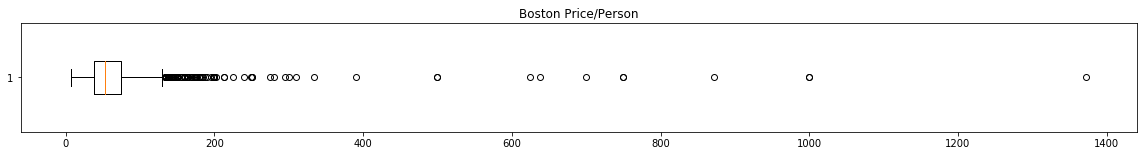

In [194]:
b_categorical = categorical_factors(boston_listing)
plt.figure(figsize=(20,2))
plt.boxplot(b_categorical['price_per_person'], vert=False, widths=0.3)
plt.title("Boston Price/Person")

Text(0.5, 1.0, 'Boston Price/Person (w/o outliers)')

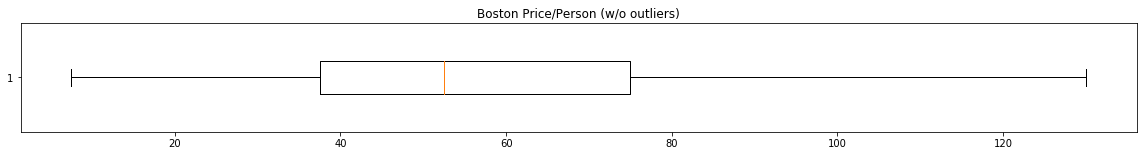

In [195]:
plt.figure(figsize=(20,2))
plt.boxplot(b_categorical['price_per_person'], vert=False, showfliers=False, widths=0.3)
plt.title("Boston Price/Person (w/o outliers)")

In [222]:
def level_price_b(df1, df2):

    for i in range(len(df2)):
        try:
            price = df1.loc[i,'price_per_person']
            if 35 < price <= 80:
                df1.loc[i, 'price_level'] = "moderate"
            elif 80 < price:
                df1.loc[i, 'price_level'] = "high"
            elif price <= 35:
                df1.loc[i, 'price_level'] = "low"
        except KeyError:
            pass

    return df1

In [223]:
level_price_b(b_categorical, boston_listing)

,price,accommodates,neighbourhood,property_type,room_type,cancellation_policy,price_per_person,price_level
0,250,4,Roslindale,House,Entire home/apt,moderate,62.50,moderate
1,65,2,Roslindale,Apartment,Private room,moderate,32.50,low
2,65,2,Roslindale,Apartment,Private room,moderate,32.50,low
4,79,2,Roslindale,House,Private room,flexible,39.50,moderate
5,75,2,Roslindale,Condominium,Private room,flexible,37.50,moderate
7,75,2,Roslindale,House,Private room,moderate,37.50,moderate
8,58,2,Roslindale,Condominium,Private room,moderate,29.00,low
9,229,5,Roslindale,Apartment,Entire home/apt,strict,45.80,moderate
10,60,2,Roslindale,House,Private room,flexible,30.00,low
11,57,1,Roslindale,House,Private room,flexible,57.00,moderate


#### Boston chi-square

In [210]:
from scipy import stats

In [224]:
level_price_df = level_price_b(b_categorical, boston_listing)
price_level_counts = level_price_df.groupby("price_level").size()
print(price_level_counts)

price_level
high         619
low          646
moderate    1774
dtype: int64


In [225]:
price_level_counts = list(price_level_counts)
uniform = [len(level_price_df)/3, len(level_price_df)/3, len(level_price_df)/3]
chi2, p = stats.chisquare(price_level_counts, uniform)
print(f"Observed: {price_level_counts}")
print(f"Uniform would be: {uniform}")
print(f"Significant difference? p={p:.4f}, chi^2={chi2:.4f}")

Observed: [619, 646, 1774]
Uniform would be: [1013.0, 1013.0, 1013.0]
Significant difference? p=0.0000, chi^2=857.8934


##### by neighborhood

In [248]:
price_level_by_neighbourhood = level_price_df.groupby(["price_level","neighbourhood"]).size()
price_level_by_neighbourhood = price_level_by_neighbourhood.unstack()
price_level_by_neighbourhood.fillna(value=0, inplace=True)
price_level_by_neighbourhood

neighbourhood,Allston-Brighton,Back Bay,Beacon Hill,Brookline,Cambridge,Charlestown,Chestnut Hill,Chinatown,Dorchester,Downtown,...,Mission Hill,North End,Roslindale,Roxbury,Somerville,South Boston,South End,Theater District,West End,West Roxbury
price_level,,,,,,,,,,,,,,,,,,,,,
high,30.0,116.0,81.0,0.0,0.0,26.0,0.0,12.0,6.0,1.0,...,12.0,29.0,0.0,9.0,0.0,48.0,107.0,12.0,17.0,1.0
low,139.0,12.0,3.0,0.0,1.0,6.0,2.0,7.0,97.0,2.0,...,26.0,17.0,18.0,34.0,7.0,22.0,11.0,1.0,13.0,20.0
moderate,194.0,162.0,90.0,8.0,6.0,47.0,2.0,59.0,92.0,5.0,...,65.0,79.0,32.0,73.0,6.0,146.0,180.0,20.0,38.0,14.0


In [250]:
chi2, p, dof, exp = stats.chi2_contingency(price_level_by_neighbourhood)
print(f"Uniform would be:\n{exp}")
print(f"\nSignificant difference? p={p:.4f}, chi^2={chi2:.4f}")

Uniform would be:
[[ 73.93780849  59.06877262  35.44126357   1.62948338   1.42579796
   16.0911484    0.81474169  15.88746298  39.71865745   1.62948338
    5.09213557  23.83119447  50.71767029   2.6479105    0.61105627
    0.40737085   5.09213557  63.95722277   1.62948338   4.07370846
   20.97959855  25.46067785  10.18427114  23.62750905   2.6479105
   43.99605133  60.69825601   6.72161895  13.85060875   7.1289898 ]
 [ 77.16288253  61.64527805  36.98716683   1.70055939   1.48798947
   16.79302402   0.8502797   16.5804541   41.45113524   1.70055939
    5.31424811  24.87068115  52.92991115   2.76340902   0.63770977
    0.42513985   5.31424811  66.74695624   1.70055939   4.25139849
   21.8947022   26.57124054  10.62849622  24.65811122   2.76340902
   45.91510365  63.34583745   7.0148075   14.45475485   7.43994735]
 [211.89930898 169.28594933 101.5715696    4.66995722   4.08621257
   46.11582757   2.33497861  45.53208292 113.83020731   4.66995722
   14.59361632  68.29812438 145.35241856   

##### by property type

In [239]:
types_to_check = ["Apartment", "House"]
price_level_by_property_type_subset = level_price_df.loc[level_price_df.property_type.isin(types_to_check)]
price_by_property = price_level_by_property_type_subset.groupby(["price_level","property_type"]).size()
price_by_property = price_by_property.unstack()
print(price_by_property)

property_type  Apartment  House
price_level                    
high                 490     40
low                  407    178
moderate            1304    256


In [251]:
chi2, p, dof, exp = stats.chi2_contingency(price_by_property)
print(f"Uniform would be:\n{exp}")
print(f"\nSignificant difference? p={p:.4f}, chi^2={chi2:.4f}")

Uniform would be:
[[ 436.08598131   93.91401869]
 [ 481.34018692  103.65981308]
 [1283.57383178  276.42616822]]

Significant difference? p=0.0000, chi^2=104.2456


##### by room type

In [252]:
price_level_by_room_type = level_price_df.groupby(["price_level","room_type"]).size()
price_level_by_room_type = price_level_by_room_type.unstack()
print(price_level_by_room_type)

room_type    Entire home/apt  Private room  Shared room
price_level                                            
high                     464           145           10
low                      283           343           20
moderate                1113           636           25


In [253]:
chi2, p, dof, exp = stats.chi2_contingency(price_level_by_room_type)
print(f"Uniform would be:\n{exp}")
print(f"\nSignificant difference? p={p:.4f}, chi^2={chi2:.4f}")

Uniform would be:
[[ 378.85488648  228.94241527   11.20269826]
 [ 395.38005923  238.92859493   11.69134584]
 [1085.76505429  656.1289898    32.10595591]]

Significant difference? p=0.0000, chi^2=136.0938


##### by cancellation policy

In [254]:
price_level_by_cp = level_price_df.groupby(["price_level","cancellation_policy"]).size()
price_level_by_cp = price_level_by_cp.unstack().fillna(value=0)
print(price_level_by_cp)

cancellation_policy  flexible  moderate  strict  super_strict_30
price_level                                                     
high                    148.0     154.0   255.0             62.0
low                     220.0     165.0   261.0              0.0
moderate                450.0     436.0   873.0             15.0


In [255]:
chi2, p, dof, exp = stats.chi2_contingency(price_level_by_cp)
print(f"Uniform would be:\n{exp}")
print(f"\nSignificant difference? p={p:.4f}, chi^2={chi2:.4f}")

Uniform would be:
[[166.61467588 153.78249424 282.91905232  15.68377756]
 [173.88219809 160.49029286 295.25962488  16.36788417]
 [477.50312603 440.7272129  810.8213228   44.94833827]]

Significant difference? p=0.0000, chi^2=200.6714


#### Seattle categorical variable analysis

In [199]:
categorical_factors(seattle_listing)

,price,accommodates,neighbourhood,property_type,room_type,cancellation_policy,price_per_person
0,85,4,Queen Anne,Apartment,Entire home/apt,moderate,21.25
1,150,4,Queen Anne,Apartment,Entire home/apt,strict,37.50
2,975,11,Queen Anne,House,Entire home/apt,strict,88.64
3,100,3,Queen Anne,Apartment,Entire home/apt,flexible,33.33
4,450,6,Queen Anne,House,Entire home/apt,strict,75.00
5,120,2,Queen Anne,House,Private room,strict,60.00
6,80,2,Queen Anne,House,Private room,moderate,40.00
7,60,2,Queen Anne,Cabin,Private room,strict,30.00
8,90,2,Queen Anne,Apartment,Private room,strict,45.00
9,150,4,Queen Anne,Apartment,Entire home/apt,strict,37.50


Text(0.5, 1.0, 'Seattle Price/Person')

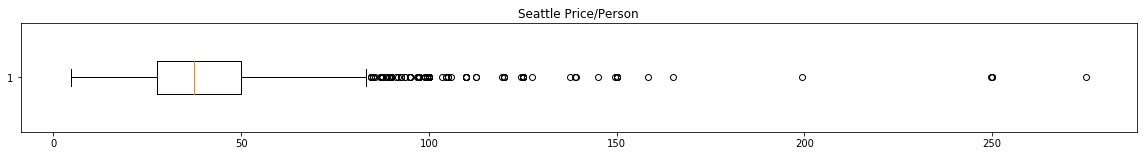

In [200]:
s_categorical = categorical_factors(seattle_listing)
plt.figure(figsize=(20,2))
plt.boxplot(s_categorical['price_per_person'], vert=False, widths=0.3)
plt.title("Seattle Price/Person")

Text(0.5, 1.0, 'Seattle Price/Person (w/o outliers)')

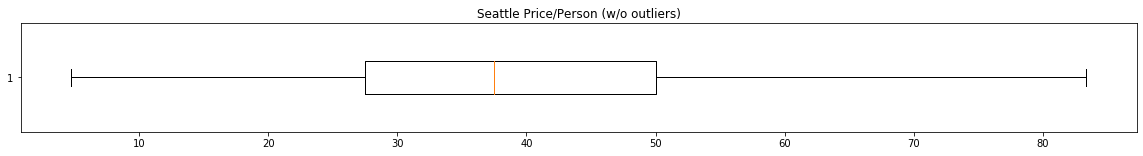

In [201]:
plt.figure(figsize=(20,2))
plt.boxplot(s_categorical['price_per_person'], vert=False, showfliers=False, widths=0.3)
plt.title("Seattle Price/Person (w/o outliers)")

In [205]:
def level_price_s(df1, df2):

    for i in range(len(df2)):
        try:
            price = df1.loc[i,'price_per_person']
            if 100 < price:
                df1.loc[i, 'price_level'] = "luxury"
            elif price <= 25:
                df1.loc[i, 'price_level'] = "economical"
            elif 25 < price <= 40:
                df1.loc[i, 'price_level'] = "lower moderate"
            elif 40 < price <= 80:
                df1.loc[i, 'price_level'] = "upper moderate"
            elif 80 < price <= 100:
                df1.loc[i, 'price_level'] = "expensive"
        except KeyError:
            pass

    return df1

In [206]:
level_price_s(s_categorical, seattle_listing)

,price,accommodates,neighbourhood,property_type,room_type,cancellation_policy,price_per_person,price_level
0,85,4,Queen Anne,Apartment,Entire home/apt,moderate,21.25,economical
1,150,4,Queen Anne,Apartment,Entire home/apt,strict,37.50,lower moderate
2,975,11,Queen Anne,House,Entire home/apt,strict,88.64,expensive
3,100,3,Queen Anne,Apartment,Entire home/apt,flexible,33.33,lower moderate
4,450,6,Queen Anne,House,Entire home/apt,strict,75.00,upper moderate
5,120,2,Queen Anne,House,Private room,strict,60.00,upper moderate
6,80,2,Queen Anne,House,Private room,moderate,40.00,lower moderate
7,60,2,Queen Anne,Cabin,Private room,strict,30.00,lower moderate
8,90,2,Queen Anne,Apartment,Private room,strict,45.00,upper moderate
9,150,4,Queen Anne,Apartment,Entire home/apt,strict,37.50,lower moderate


#### Seattle chi-square

In [257]:
level_price_df_s = level_price_s(s_categorical, seattle_listing)
price_level_counts = level_price_df_s.groupby("price_level").size()
print(price_level_counts)

price_level
economical         672
expensive           95
lower moderate    1320
luxury              44
upper moderate    1270
dtype: int64


In [258]:
price_level_counts = list(price_level_counts)
uniform = [len(level_price_df)/5, len(level_price_df)/5, len(level_price_df)/5, len(level_price_df)/5, len(level_price_df)/5]
chi2, p = stats.chisquare(price_level_counts, uniform)
print(f"Observed: {price_level_counts}")
print(f"Uniform would be: {uniform}")
print(f"Significant difference? p={p:.4f}, chi^2={chi2:.4f}")

Observed: [672, 95, 1320, 44, 1270]
Uniform would be: [680.2, 680.2, 680.2, 680.2, 680.2]
Significant difference? p=0.0000, chi^2=2211.8271


##### by neighborhood

In [259]:
price_level_by_neighbourhood = level_price_df.groupby(["price_level","neighbourhood"]).size()
price_level_by_neighbourhood = price_level_by_neighbourhood.unstack()
price_level_by_neighbourhood.fillna(value=0, inplace=True)
price_level_by_neighbourhood

neighbourhood,Alki,Arbor Heights,Atlantic,Ballard,Belltown,Bitter Lake,Brighton,Broadview,Broadway,Bryant,...,Stevens,The Junction,University District,Victory Heights,View Ridge,Wallingford,Wedgewood,Westlake,Windermere,Yesler Terrace
price_level,,,,,,,,,,,,,,,,,,,,,
economical,1.0,1.0,10.0,42.0,30.0,8.0,2.0,7.0,1.0,9.0,...,7.0,6.0,31.0,4.0,3.0,26.0,4.0,1.0,0.0,0.0
expensive,0.0,0.0,0.0,3.0,8.0,1.0,0.0,0.0,0.0,0.0,...,4.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0
lower moderate,10.0,1.0,29.0,106.0,68.0,1.0,3.0,8.0,2.0,13.0,...,37.0,17.0,44.0,5.0,1.0,74.0,2.0,1.0,3.0,4.0
luxury,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
upper moderate,10.0,1.0,11.0,62.0,95.0,3.0,0.0,1.0,2.0,10.0,...,47.0,13.0,30.0,3.0,1.0,41.0,8.0,8.0,7.0,8.0


In [260]:
chi2, p, dof, exp = stats.chi2_contingency(price_level_by_neighbourhood)
print(f"Uniform would be:\n{exp}")
print(f"\nSignificant difference? p={p:.4f}, chi^2={chi2:.4f}")

Uniform would be:
[[4.54454572e+00 5.92766833e-01 9.87944722e+00 4.20864452e+01
  4.03081447e+01 2.56865628e+00 9.87944722e-01 3.16142311e+00
  9.87944722e-01 6.32284622e+00 6.93537195e+01 1.58071156e+00
  1.60047045e+01 1.20529256e+01 4.14936783e+00 2.37106733e+00
  8.10114672e+00 1.97588944e-01 1.97588944e+00 2.07468392e+01
  2.92431638e+01 3.55660100e+00 5.73007939e+00 1.38312261e+00
  1.02746251e+01 1.56095266e+01 2.76624522e+00 2.56865628e+00
  2.17347839e+00 2.37106733e+00 1.18553367e+00 5.92766833e-01
  1.38312261e+00 3.35901206e+00 1.77830050e+00 8.69391355e+00
  2.37106733e+00 1.63998824e+01 3.16142311e+00 7.90355778e+00
  1.08673919e+01 8.10114672e+00 3.35901206e+00 1.77830050e+00
  3.79370773e+01 3.75418994e+00 9.08909144e+00 9.48426933e+00
  2.17347839e+00 1.87709497e+01 1.97588944e-01 5.33490150e+00
  2.37106733e+00 1.10649809e+01 3.95177889e-01 7.70596883e+00
  5.92766833e-01 2.76624522e+00 2.76624522e+00 3.69491326e+01
  3.55660100e+00 1.16577477e+01 1.58071156e+00 5.334

##### by property type

In [261]:
types_to_check = ["Apartment", "House"]
price_level_by_property_type_subset = level_price_df.loc[level_price_df.property_type.isin(types_to_check)]
price_by_property = price_level_by_property_type_subset.groupby(["price_level","property_type"]).size()
price_by_property = price_by_property.unstack()
print(price_by_property)

property_type   Apartment  House
price_level                     
economical            276    347
expensive              47     28
lower moderate        524    672
luxury                 20     14
upper moderate        645    495


In [262]:
chi2, p, dof, exp = stats.chi2_contingency(price_by_property)
print(f"Uniform would be:\n{exp}")
print(f"\nSignificant difference? p={p:.4f}, chi^2={chi2:.4f}")

Uniform would be:
[[307.03259452 315.96740548]
 [ 36.96219035  38.03780965]
 [589.42372881 606.57627119]
 [ 16.75619296  17.24380704]
 [561.82529335 578.17470665]]

Significant difference? p=0.0000, chi^2=51.3944


##### by room type

In [264]:
price_level_by_room_type = level_price_df.groupby(["price_level","room_type"]).size()
price_level_by_room_type = price_level_by_room_type.unstack().fillna(value=0)
print(price_level_by_room_type)

room_type       Entire home/apt  Private room  Shared room
price_level                                               
economical                434.0         215.0         23.0
expensive                  68.0          27.0          0.0
lower moderate            819.0         457.0         44.0
luxury                     26.0          18.0          0.0
upper moderate            936.0         303.0         31.0


In [265]:
chi2, p, dof, exp = stats.chi2_contingency(price_level_by_room_type)
print(f"Uniform would be:\n{exp}")
print(f"\nSignificant difference? p={p:.4f}, chi^2={chi2:.4f}")

Uniform would be:
[[451.09556013 201.54072332  19.36371655]
 [ 63.77094972  28.49162011   2.73743017]
 [886.08056454 395.88356366  38.0358718 ]
 [ 29.53601882  13.19611879   1.26786239]
 [852.51690679 380.88797413  36.59511908]]

Significant difference? p=0.0000, chi^2=49.1721


##### by cancellation policy

In [266]:
price_level_by_cp = level_price_df.groupby(["price_level","cancellation_policy"]).size()
price_level_by_cp = price_level_by_cp.unstack().fillna(value=0)
print(price_level_by_cp)

cancellation_policy  flexible  moderate  strict
price_level                                    
economical                180       233     259
expensive                  31        32      32
lower moderate            370       457     493
luxury                     19         8      17
upper moderate            378       396     496


In [267]:
chi2, p, dof, exp = stats.chi2_contingency(price_level_by_cp)
print(f"Uniform would be:\n{exp}")
print(f"\nSignificant difference? p={p:.4f}, chi^2={chi2:.4f}")

Uniform would be:
[[193.24198765 222.48515143 256.27286092]
 [ 27.31843575  31.45251397  36.22905028]
 [379.58247574 437.02440459 503.39311967]
 [ 12.65274919  14.56748015  16.77977066]
 [365.20435166 420.47044987 484.32519847]]

Significant difference? p=0.1466, chi^2=12.1039


# Case Comparison (review&listing)

In [269]:
boston_high_review_score_df = boston_listing.loc[boston_listing.id.isin(boston_high_score_listing)]
boston_high_review_score_df

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
319,3593290,https://www.airbnb.com/rooms/3593290,20160906204935,2016-09-07,Fab House in Hip J.P.,Newly renovated open and airy single family ho...,Open and airy recently renovated single family...,Newly renovated open and airy single family ho...,none,NaN,...,10.0,f,NaN,NaN,f,moderate,f,f,1,0.35
353,5212321,https://www.airbnb.com/rooms/5212321,20160906204935,2016-09-07,Wonderful home Great Neighborhood mins from Bo...,"If you like friendly, diverse & family oriente...","There are two bedrooms, a music room with (wit...","If you like friendly, diverse & family oriente...",none,Jamaica plain is one of the most highly sought...,...,10.0,f,NaN,NaN,f,strict,f,f,2,0.13
373,6914622,https://www.airbnb.com/rooms/6914622,20160906204935,2016-09-07,Treetop Haven-Eclectic Boston Area,"Beautifully decorated, clean, 2nd Fl condo, pe...","If you love nature, with all of the amenities,...","Beautifully decorated, clean, 2nd Fl condo, pe...",none,"Very welcoming, overall safe, and accessible n...",...,10.0,f,NaN,NaN,f,strict,f,f,1,0.50
811,14813006,https://www.airbnb.com/rooms/14813006,20160906204935,2016-09-07,MODERN 3BR/2B apartment near Fenway!,Hey there! =) Looking for an awesome place to ...,No parties thank you. Our 2 floor home is loca...,Hey there! =) Looking for an awesome place to ...,none,No parties thank you. The neighborhood is tota...,...,10.0,f,NaN,NaN,t,flexible,f,f,1,1.00
1088,8201104,https://www.airbnb.com/rooms/8201104,20160906204935,2016-09-07,"Boston, South End - 3 Bedrooms","Condominium with Patio, walking distance to Co...",NOTICE: You must be able to rent a minimum of...,"Condominium with Patio, walking distance to Co...",none,Bring your walking shoes!!! There is a conven...,...,8.0,f,NaN,NaN,f,moderate,f,f,5,0.26
1135,14125957,https://www.airbnb.com/rooms/14125957,20160906204935,2016-09-07,South End garden studio in excellent location,Historic brownstone in prized location is less...,NaN,Historic brownstone in prized location is less...,none,NaN,...,10.0,f,NaN,NaN,f,strict,f,f,1,7.00
1261,12603280,https://www.airbnb.com/rooms/12603280,20160906204935,2016-09-07,"Saint Botolph Street, Lux South End/Back Bay 1bd",Perfect for extended stay in Boston. Enjoy ame...,-Every other week housekeeping included! -Full...,Perfect for extended stay in Boston. Enjoy ame...,none,NaN,...,8.0,f,NaN,NaN,f,moderate,f,f,13,0.27
1370,14603013,https://www.airbnb.com/rooms/14603013,20160906204935,2016-09-07,Back Bay Pied a Terre. Fabulous location!,"My place is close to Boston Public Gardens, Ne...","A charming unit located in historic Back Bay, ...","My place is close to Boston Public Gardens, Ne...",none,"Quiet part of Beacon Street, however, within a...",...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
1860,7092874,https://www.airbnb.com/rooms/7092874,20160906204935,2016-09-07,Well lit condo in BeaconHill Boston,Fully furnished 2 bedroom apartment in histori...,The building was built in the 19th century and...,Fully furnished 2 bedroom apartment in histori...,none,Accessible to everything,...,10.0,f,NaN,NaN,f,strict,f,f,1,0.07
2831,5584915,https://www.airbnb.com/rooms/5584915,20160906204935,2016-09-07,Peaceful 2-Bedroom Artist's Home,"Single-family home with 2 bedrooms, 2 full bat...","Owned by an artist/dancer couple, this house, ...","Single-family home with 2 bedrooms, 2 full bat...",none,A true urban oasis. Explore historic Lower Mil...,...,10.0,f,NaN,NaN,f,strict,f,f,1,0.15


In [270]:
boston_low_review_score_df = boston_listing.loc[boston_listing.id.isin(boston_low_score_listing)]
boston_low_review_score_df

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
513,4409653,https://www.airbnb.com/rooms/4409653,20160906204935,2016-09-07,"Lux Longwood 1BR w/pool, gym & WiFi",This amazing property is a 21 story high-rise ...,Your beautiful apartment home features parquet...,This amazing property is a 21 story high-rise ...,none,"The Museum of Fine Arts, Copley Plaza and Fanu...",...,2.0,f,NaN,NaN,f,moderate,f,t,61,0.07
1659,14532696,https://www.airbnb.com/rooms/14532696,20160906204935,2016-09-07,Cosy bedroom near Airport/Downtown and the Beach.,"My place is close to Little Asia, Orient Heigh...","This apartment is particularly well located, w...","My place is close to Little Asia, Orient Heigh...",none,"East Boston, commonly referred to as Eastie, i...",...,8.0,f,NaN,NaN,f,flexible,f,f,2,2.00
2226,1867754,https://www.airbnb.com/rooms/1867754,20160906204935,2016-09-07,Lux 1BR near Fenway w/WiFi,Our 1 Bedroom apartment in this 7 floor Mid-Ri...,Lovely bay windows and linen closets are some ...,Our 1 Bedroom apartment in this 7 floor Mid-Ri...,none,Our apartment is located in an elegant new lux...,...,4.0,f,NaN,NaN,f,moderate,f,t,61,0.03
2355,10036037,https://www.airbnb.com/rooms/10036037,20160906204935,2016-09-07,New Luxury 2BR-Apartment at Fenway,This furnished apartment is complete with a fu...,B994,This furnished apartment is complete with a fu...,none,NaN,...,4.0,f,NaN,NaN,f,strict,f,f,136,0.21
2392,13751871,https://www.airbnb.com/rooms/13751871,20160906204935,2016-09-07,Centrally located studio apartment,"My place is close to subway stops, Boston Symp...",NaN,"My place is close to subway stops, Boston Symp...",none,NaN,...,7.0,f,NaN,NaN,t,strict,f,f,1,1.88
2943,6887926,https://www.airbnb.com/rooms/6887926,20160906204935,2016-09-07,"Umass,MGH,Harvard,MIT,Longwood A3",Come live with other international students/do...,NaN,Come live with other international students/do...,none,NaN,...,3.0,f,NaN,NaN,f,strict,f,f,15,0.21
3514,6277566,https://www.airbnb.com/rooms/6277566,20160906204935,2016-09-07,10 Min Walk to HBS and Harvard Sq,We live in a multi-story home. The 3rd floor ...,"Close access to subway stops, bus routes, and ...",We live in a multi-story home. The 3rd floor ...,none,NaN,...,7.0,f,NaN,NaN,f,flexible,f,f,1,0.19


In [271]:
seattle_high_review_score_df = seattle_listing.loc[seattle_listing.id.isin(seattle_high_score_listing)]
seattle_high_review_score_df

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
15,8988178,https://www.airbnb.com/rooms/8988178,20160104002432,2016-01-04,"Lovely Queen Anne Cottage, 2 BR","This home is full of light, art and comfort. 5...","The Space This is a 1000 square foot, two bedr...","This home is full of light, art and comfort. 5...",none,Queen Anne is a charming and very safe neighbo...,...,8.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.73
194,9367465,https://www.airbnb.com/rooms/9367465,20160104002432,2016-01-04,Crow's Nest Cottage,"Crow's Nest Cottage is a brand new, free stand...",This is a brand new cozy cottage with a loft b...,"Crow's Nest Cottage is a brand new, free stand...",none,"Fremont is considered the ""Center of the Unive...",...,10.0,f,NaN,WASHINGTON,f,flexible,f,f,1,0.86
223,7513198,https://www.airbnb.com/rooms/7513198,20160104002432,2016-01-04,Spectacular Queen Anne View Condo,Located near the top of Queen Anne Hill overlo...,NaN,Located near the top of Queen Anne Hill overlo...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,0.21
225,9694921,https://www.airbnb.com/rooms/9694921,20160104002432,2016-01-04,Remodeled Historic House in WestLk,This landmark historic Spanish-mission home is...,This light and bright Seattle Spanish-mission ...,This landmark historic Spanish-mission home is...,none,Westlake is close to everything. Enjoy a strol...,...,10.0,f,NaN,WASHINGTON,f,flexible,f,f,1,1.00
271,8088447,https://www.airbnb.com/rooms/8088447,20160104002432,2016-01-04,Central 1-BR with Lake Union View,This pleasant and centrally located apartment ...,Our home matches a calm atmosphere with a conv...,This pleasant and centrally located apartment ...,none,The Westlake neighborhood's proximity to Lake ...,...,10.0,f,NaN,WASHINGTON,f,flexible,f,f,1,0.53
303,6915487,https://www.airbnb.com/rooms/6915487,20160104002432,2016-01-04,Upper House near UW and Greenlake,Location and sparse elegance makes this a grea...,"Spacious, airy, bright home with beautiful flo...",Location and sparse elegance makes this a grea...,none,Woodlawn is 3 blocks away from Seattle's treas...,...,8.0,f,NaN,WASHINGTON,f,strict,f,f,2,0.25
356,5128160,https://www.airbnb.com/rooms/5128160,20160104002432,2016-01-04,Family-Ready Craftsman Home,Fully-renovated charming Seattle home with par...,Our home is a classic 1920's Craftsman style b...,Fully-renovated charming Seattle home with par...,none,Wallingford is one of the classic turn-of-the-...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,0.79
370,8765219,https://www.airbnb.com/rooms/8765219,20160104002432,2016-01-04,Craftsman Home in Wallingford!,This Craftsman home is located in the prime Wa...,NaN,This Craftsman home is located in the prime Wa...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,flexible,f,f,1,0.98
383,6714817,https://www.airbnb.com/rooms/6714817,20160104002432,2016-01-04,"Bright, Modern, Seattle Classic.",Our apartment has recently been completely ren...,4 Night minimum for your stay. Our apartment ...,Our apartment has recently been completely ren...,none,Wallingford is a neighborhood in north central...,...,9.0,f,NaN,WASHINGTON,f,flexible,f,f,1,0.31
435,3888986,https://www.airbnb.com/rooms/3888986,20160104002432,2016-01-04,Lake Union Hacker House - 2FL 2p L,"Built, run and supported by Seattle tech and s...","*Note: This fall, there will be major renovati...","Built, run and supported by Seattle tech and s...",none,Wallingford is a mostly-residential neighborho...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,37,0.20


In [272]:
seattle_low_review_score_df = seattle_listing.loc[seattle_listing.id.isin(seattle_low_score_listing)]
seattle_low_review_score_df

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
805,1589461,https://www.airbnb.com/rooms/1589461,20160104002432,2016-01-04,Hardwood Clean Quiet Walk to UW (52,It has a Walk Score of 100 out of 100--Walker'...,Furnished elegant and bright one bedroom apart...,It has a Walk Score of 100 out of 100--Walker'...,none,It is located in the bustling and vibrant Univ...,...,8.0,f,NaN,WASHINGTON,f,strict,f,f,34,0.18
1609,8505421,https://www.airbnb.com/rooms/8505421,20160104002432,2016-01-04,WONDERFUL LOCATION,This beautiful space could not be in a more co...,NaN,This beautiful space could not be in a more co...,none,NaN,...,8.0,f,NaN,WASHINGTON,f,moderate,f,f,1,0.30
2320,8474294,https://www.airbnb.com/rooms/8474294,20160104002432,2016-01-04,Cozy 2Br/2Bt Apt close to park,"Our cozy two bedroom/ two bathroom apartment, ...",Please feel free to look at our other listings...,"Our cozy two bedroom/ two bathroom apartment, ...",none,The Neighborhood Start the day off right with ...,...,8.0,f,NaN,WASHINGTON,f,strict,f,f,2,0.38
